In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.1 MB/s eta 0:00:00


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Commented out IPython magic to ensure Python compatibility.
import os
import sys
import time
import glob
import random
import argparse
import pickle
import numpy as np
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import lfilter
import scipy.signal as signal
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Add, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten,
    Conv2D, DepthwiseConv2D, MaxPooling2D,
    BatchNormalization, GlobalAveragePooling2D,
    Add
)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Add, ReLU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# %matplotlib inline

class DataSet2(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._cls = cls
        self._epochs_done = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_done(self):
        return self._epochs_done

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]

def read_train_sets2(train_path, classes, validation_size):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, img_names, cls = load_train2(train_path, classes)  # 2 calculating, 3 loading
    images, labels, img_names, cls = shuffle(images, labels, img_names, cls)

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_img_names = img_names[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_img_names = img_names[validation_size:]
    train_cls = cls[validation_size:]
#     print('Training dataset shape:',len (train_images))
    data_sets.train = DataSet2(train_images, train_labels, train_img_names, train_cls)
    data_sets.valid = DataSet2(validation_images, validation_labels, validation_img_names, validation_cls)

    return data_sets

def load_train2(train_path, classes):
    samples = []
    labels = []
    sample_names = []
    cls = []

    for fields in classes:
        index = classes.index(fields)
        path = os.path.join(train_path, fields, '*.npy')
        files = glob.glob(path)
        for fl in files:
            iq_samples = np.load(fl)
            real = np.real(iq_samples)
            imag = np.imag(iq_samples)

            iq_samples = np.ravel(np.column_stack((real, imag)))

            multiple = False
            if multiple:
                iq_samples1 = iq_samples[:1568]
                iq_samples1 = iq_samples1.reshape(28, 28, 2)
                iq_samples2 = iq_samples[1568:3136]
                iq_samples2 = iq_samples2.reshape(28, 28, 2)
                iq_samples3 = iq_samples[3136:4704]
                iq_samples3 = iq_samples3.reshape(28, 28, 2)
                iq_samples4 = iq_samples[4704:6272]
                iq_samples4 = iq_samples4.reshape(28, 28, 2)
                samples.append(iq_samples1)
                samples.append(iq_samples2)
                samples.append(iq_samples3)
                samples.append(iq_samples4)

                flbase = os.path.basename(fl)
                label = np.zeros(len(classes))
                label[index] = 1.0

                labels.append(label)
                labels.append(label)
                labels.append(label)
                labels.append(label)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
            else:
                iq_samples = iq_samples[:1568]
                iq_samples = iq_samples.reshape(28, 28, 2)
                samples.append(iq_samples)

                label = np.zeros(len(classes))
                label[index] = 1.0
                labels.append(label)
                flbase = os.path.basename(fl)
                sample_names.append(flbase)
                cls.append(fields)

    samples = np.array(samples)
    labels = np.array(labels)
    sample_names = np.array(sample_names)
    cls = np.array(cls)
    return samples, labels, sample_names, cls

# Function to read the samples from _prediction_samples.dat files

def read_samples_sdr(freq):
    sdr = RtlSdr()
    sdr.sample_rate = sample_rate
    sdr.err_ppm = 56   # change it to yours
    sdr.gain = 'auto'

    f_offset = 250000  # shifted tune to avoid DC
    sdr.center_freq = freq - f_offset
    time.sleep(0.06)
    iq_samples = sdr.read_samples(1221376)
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples


def read_samples(freq):
    f_offset = 250000  # Shifted tune to avoid DC
    samp = np.fromfile(str(freq)+'_prediction_samples.dat',np.uint8)+np.int8(-127) # Adding a signed int8 to an unsigned one results in an int16 array
    x1 = samp[::2]/128 # Even samples are real(In-phase)
    x2 = samp[1::2]/128 # Odd samples are imaginary(Quadrature-phase)
    iq_samples = x1+x2*1j # Create the complex data samples
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # Shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples

########### Main Code #################################

############ Data for training the model #################
train_path ='/content/drive/MyDrive/Dataset_Deep_Radio/Dataset_Deep_Radio/training_data'
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))] # Gets classes from all the folders mentioned under training_data folder
print(classes)
# classes = ['BPSK','GMSK','QPSK']
num_classes = len(classes)
data = read_train_sets2(train_path, classes, validation_size=0.2) # Gets the data object using a class in dataset2.py

Xtrain = data.train.images
Ytrain = data.train.labels
Xtest = data.valid.images
Ytest = data.valid.labels

print('Training dataset shape:',Xtrain.shape)
print('Training dataset label:',Ytrain.shape)
print('Testing dataset shape:',Xtest.shape)
print('Testing dataset label:',Ytest.shape)

['16QAM', '64QAM', 'BPSK', 'CPFSK', 'GFSK', 'GMSK', 'OTHER', 'QPSK']
Training dataset shape: (2400, 28, 28, 2)
Training dataset label: (2400, 8)
Testing dataset shape: (600, 28, 28, 2)
Testing dataset label: (600, 8)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Add, ReLU
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


# -----------------------------
# Model definition
# -----------------------------
class EnhancedOptimizedCNN:
    def __init__(self, input_shape, num_classes, alpha):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.alpha = alpha
        self.model = None

    def _inverted_residual_block_v2(self, x, filters, strides, expand_ratio, alpha, dropout_rate):
        input_channels = int(x.shape[-1])
        expanded_channels = int(input_channels * expand_ratio * alpha)
        output_channels = int(filters * alpha)

        if expand_ratio != 1:
            x_expanded = Conv2D(expanded_channels, (1, 1), padding='same', use_bias=False)(x)
            x_expanded = BatchNormalization()(x_expanded)
            x_expanded = ReLU(max_value=6.0)(x_expanded)
            x_expanded = Dropout(dropout_rate)(x_expanded)
        else:
            x_expanded = x

        x_dw = DepthwiseConv2D((3, 3), strides=strides, padding='same', use_bias=False)(x_expanded)
        x_dw = BatchNormalization()(x_dw)
        x_dw = ReLU(max_value=6.0)(x_dw)

        x_proj = Conv2D(output_channels, (1, 1), padding='same', use_bias=False)(x_dw)
        x_proj = BatchNormalization()(x_proj)

        if strides == 1 and input_channels == output_channels:
            x_proj = Dropout(dropout_rate / 2)(x_proj)
            return Add()([x, x_proj])
        else:
            return x_proj

    def _build_enhanced_model(self, dropout_rates):
        inputs = Input(shape=self.input_shape)

        x = Conv2D(int(12 * self.alpha), (3, 3), strides=1, padding='same', use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU(max_value=6.0)(x)
        x = Dropout(dropout_rates[0])(x)

        x = self._inverted_residual_block_v2(x, 20, strides=2, expand_ratio=1,
                                             alpha=self.alpha, dropout_rate=dropout_rates[1])
        x = self._inverted_residual_block_v2(x, 24, strides=1, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[2])
        x = self._inverted_residual_block_v2(x, 48, strides=2, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[3])
        x = self._inverted_residual_block_v2(x, 64, strides=1, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[4])

        x = GlobalAveragePooling2D()(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(dropout_rates[5])(x)

        outputs = Dense(self.num_classes, activation='softmax')(x)
        return Model(inputs, outputs, name='EnhancedOptimizedCNN_AdamW')

    def create_model(self, dropout_rates):
        self.model = self._build_enhanced_model(dropout_rates)
        return self.model


# -----------------------------
# Augmentation
# -----------------------------
class AdvancedRFAugmentation:
    def __init__(self, snr_range, augmentation_factor):
        self.snr_range = snr_range
        self.augmentation_factor = augmentation_factor

    def add_awgn(self, signal, snr_db):
        snr_linear = 10.0 ** (snr_db / 10.0)
        if signal.shape[-1] == 2:
            signal_power = np.mean(signal[:, :, 0] ** 2 + signal[:, :, 1] ** 2)
        else:
            signal_power = np.mean(signal ** 2)
        noise_power = signal_power / snr_linear
        noise_std = np.sqrt(noise_power / 2)

        if np.random.random() > 0.8:
            white_noise = np.random.normal(0, noise_std, signal.shape)
            colored_noise = np.zeros_like(white_noise)
            for i in range(1, signal.shape[0]):
                colored_noise[i] = 0.7 * colored_noise[i - 1] + 0.3 * white_noise[i]
            noise = colored_noise
        else:
            noise = np.random.normal(0, noise_std, signal.shape)

        return (signal + noise).astype(np.float32)

    def add_frequency_selective_fading(self, signal):
        if signal.shape[-1] != 2:
            return signal
        if np.random.random() > 0.7:
            delay = np.random.randint(1, 4)
            amplitude = np.random.uniform(0.3, 0.7)
            delayed_signal = np.roll(signal, delay, axis=0) * amplitude
            return signal + delayed_signal
        return signal

    def add_phase_noise(self, signal, phase_std=0.15):
        if signal.shape[-1] != 2:
            return signal
        phase_noise = np.random.normal(0, phase_std, signal.shape[:2])
        for i in range(1, signal.shape[0]):
            phase_noise[i] = 0.9 * phase_noise[i - 1] + 0.1 * phase_noise[i]
        cos_noise = np.cos(phase_noise)
        sin_noise = np.sin(phase_noise)
        i_noisy = signal[:, :, 0] * cos_noise - signal[:, :, 1] * sin_noise
        q_noisy = signal[:, :, 0] * sin_noise + signal[:, :, 1] * cos_noise
        result = signal.copy()
        result[:, :, 0] = i_noisy
        result[:, :, 1] = q_noisy
        return result

    def augment_batch_enhanced(self, signals, labels):
        augmented_signals, augmented_labels = [], []
        for i in range(len(signals)):
            augmented_signals.append(signals[i])
            augmented_labels.append(labels[i])
            for _ in range(self.augmentation_factor):
                snr_db = np.random.uniform(self.snr_range[0], self.snr_range[1])
                augmented_signal = self.add_awgn(signals[i], snr_db)
                if np.random.random() > 0.6:
                    augmented_signal = self.add_frequency_selective_fading(augmented_signal)
                if np.random.random() > 0.7:
                    augmented_signal = self.add_phase_noise(augmented_signal)
                augmented_signals.append(augmented_signal)
                augmented_labels.append(labels[i])
        return np.array(augmented_signals), np.array(augmented_labels)


# -----------------------------
# Training pipeline
# -----------------------------
class ClassWeightedTrainingPipeline:
    def __init__(self, model, augmentor, classes):
        self.model = model
        self.augmentor = augmentor
        self.classes = classes
        self.history = None

    def compute_class_weights(self, y_train):
        y_train_labels = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
        return dict(enumerate(class_weights))

    def create_enhanced_callbacks(self, checkpoint_path, patience_es, patience_lr, min_delta):
        return [
            EarlyStopping(monitor='val_loss', patience=patience_es, restore_best_weights=True, verbose=1, min_delta=min_delta),
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=patience_lr, min_lr=1e-8, verbose=1, cooldown=1),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')
        ]

    def train_enhanced_model(self, X_train, y_train, Xtest, Ytest,
                             epochs, batch_size, lr, weight_decay,
                             beta_1, beta_2,
                             patience_es, patience_lr, min_delta, checkpoint_path):

        X_train_aug, y_train_aug = self.augmentor.augment_batch_enhanced(X_train, y_train)
        class_weights = self.compute_class_weights(y_train_aug)
        callbacks = self.create_enhanced_callbacks(checkpoint_path, patience_es, patience_lr, min_delta)

        try:
            optimizer = tf.keras.optimizers.AdamW(
                learning_rate=lr,
                weight_decay=weight_decay,
                beta_1=beta_1,
                beta_2=beta_2
            )
        except Exception:
            import tensorflow_addons as tfa
            optimizer = tfa.optimizers.AdamW(
                learning_rate=lr,
                weight_decay=weight_decay,
                beta_1=beta_1,
                beta_2=beta_2,
            )

        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(
            X_train_aug, y_train_aug,
            validation_data=(Xtest, Ytest),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1,
            shuffle=True
        )
        return self.history

In [ ]:
# ===== MODEL HYPERPARAMS =====
input_shape = (28, 28, 2)
num_classes = num_classes
# dropout_rates = [0.1, 0.1, 0.15, 0.2, 0.25, 0.5]

# ===== AUGMENTATION HYPERPARAMS =====
snr_range = (-10, 30)
augmentation_factor = 6


patience_es = 6
patience_lr = 3
min_delta = 5e-4
checkpoint_path = "enhanced_best_model.keras"

In [ ]:
import optuna
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

# --- Your model, augmentation, and pipeline classes from your code here ---
# (Paste EnhancedOptimizedCNN, AdvancedRFAugmentation, ClassWeightedTrainingPipeline)

# ===================
# Custom Objective
# ===================
def objective(trial):
    # ---- Suggest parameters ----
    alpha = trial.suggest_float("alpha", 0.6, 1.0)
    lr = trial.suggest_float("learning_rate", 5e-5, 2e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 3e-4, log=True)
    beta_1 = trial.suggest_float("beta_1", 0.85, 0.95)
    beta_2 = trial.suggest_float("beta_2", 0.98, 0.999)
    batch_size = trial.suggest_categorical("batch_size", [16, 24, 32])

    # --- Dropout rates fixed ---
    dropout_rates = [0.1, 0.1, 0.15, 0.2, 0.25, 0.5]

    # --- Create model ---
    model_obj = EnhancedOptimizedCNN(input_shape, num_classes, alpha)
    model = model_obj.create_model(dropout_rates)

    augmentor = AdvancedRFAugmentation(snr_range, augmentation_factor)
    pipeline = ClassWeightedTrainingPipeline(model, augmentor, classes=np.arange(num_classes))

    # --- Train ---
    history = pipeline.train_enhanced_model(
        Xtrain, Ytrain,
        Xtest, Ytest,
        epochs=40,  # shorter for tuning
        batch_size=batch_size,
        lr=lr,
        weight_decay=weight_decay,
        beta_1=beta_1,
        beta_2=beta_2,
        patience_es=5,
        patience_lr=3,
        min_delta=5e-4,
        checkpoint_path=f"trial_{trial.number}_best_model.keras"
    )

    # --- Predictions ---
    y_pred = model.predict(Xtest)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(Ytest, axis=1)

    acc = accuracy_score(y_true_labels, y_pred_labels)
    f1 = f1_score(y_true_labels, y_pred_labels, average="macro")

    # --- Smoothness penalty ---
    val_loss_curve = np.array(history.history["val_loss"])
    train_loss_curve = np.array(history.history["loss"])
    curve_gap = np.mean(np.abs(train_loss_curve - val_loss_curve))  # smaller = smoother fit
    smoothness_score = 1 / (1 + curve_gap)  # closer to 1 if curves are close

    # --- Plot curves per run ---
    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"Trial {trial.number} - acc: {acc:.3f}, f1: {f1:.3f}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"trial_{trial.number}_loss.png")
    plt.close()

    # --- Combine score: accuracy + f1 + smoothness ---
    final_score = (acc + f1) / 2 * smoothness_score
    trial.set_user_attr("accuracy", acc)
    trial.set_user_attr("f1", f1)
    trial.set_user_attr("smoothness", smoothness_score)

    return final_score


# ===================
# Run Optimization
# ===================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# --- Print best params ---
print("Best Params:", study.best_params)
print("Best Accuracy:", study.best_trial.user_attrs["accuracy"])
print("Best F1:", study.best_trial.user_attrs["f1"])
print("Best Smoothness:", study.best_trial.user_attrs["smoothness"])


[I 2025-08-14 15:20:32,936] A new study created in memory with name: no-name-53d681c4-a6fe-40a1-a026-a0a212fdea75


Epoch 1/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2386 - loss: 1.9248
Epoch 1: val_loss improved from inf to 2.18295, saving model to trial_0_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.2389 - loss: 1.9241 - val_accuracy: 0.1233 - val_loss: 2.1830 - learning_rate: 1.8258e-04
Epoch 2/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3998 - loss: 1.4893
Epoch 2: val_loss improved from 2.18295 to 1.48544, saving model to trial_0_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3998 - loss: 1.4892 - val_accuracy: 0.3067 - val_loss: 1.4854 - learning_rate: 1.8258e-04
Epoch 3/40
439/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4522 - loss: 1.3343
Epoch 3: val_loss improved from 1.48544 to 1.30402, saving model to trial_0_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4524 - loss: 1.3340 - val_accuracy: 0.3433 - val_loss: 1.3040 - learning_rate: 1.8258e-04
Epoch 4/40
446/450 ━━━━━━━━━━━

[I 2025-08-14 15:22:29,300] Trial 0 finished with value: 0.7117787007110247 and parameters: {'alpha': 0.8243236824907616, 'learning_rate': 0.00018257534666431187, 'weight_decay': 0.00018936381734856089, 'beta_1': 0.8827606083396449, 'beta_2': 0.9947246075339508, 'batch_size': 16}. Best is trial 0 with value: 0.7117787007110247.


Epoch 1/40
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1901 - loss: 2.0165
Epoch 1: val_loss improved from inf to 2.07986, saving model to trial_1_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.1905 - loss: 2.0158 - val_accuracy: 0.1167 - val_loss: 2.0799 - learning_rate: 7.7800e-05
Epoch 2/40
290/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3695 - loss: 1.6631
Epoch 2: val_loss improved from 2.07986 to 1.75015, saving model to trial_1_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3696 - loss: 1.6618 - val_accuracy: 0.1417 - val_loss: 1.7502 - learning_rate: 7.7800e-05
Epoch 3/40
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4093 - loss: 1.5061
Epoch 3: val_loss improved from 1.75015 to 1.51231, saving model to trial_1_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4096 - loss: 1.5052 - val_accuracy: 0.3367 - val_loss: 1.5123 - learning_rate: 7.7800e-05
Epoch 4/40
291/300 ━━━━━━━━━━━

[I 2025-08-14 15:24:29,994] Trial 1 finished with value: 0.6167388503998906 and parameters: {'alpha': 0.7586372468608075, 'learning_rate': 7.779998676919078e-05, 'weight_decay': 0.0002670591534835334, 'beta_1': 0.9437190132679246, 'beta_2': 0.99731532003315, 'batch_size': 24}. Best is trial 0 with value: 0.7117787007110247.


Epoch 1/40
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1982 - loss: 1.9874
Epoch 1: val_loss improved from inf to 2.14910, saving model to trial_2_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.1994 - loss: 1.9847 - val_accuracy: 0.1283 - val_loss: 2.1491 - learning_rate: 9.3295e-05
Epoch 2/40
218/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3230 - loss: 1.6896
Epoch 2: val_loss did not improve from 2.14910
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3235 - loss: 1.6885 - val_accuracy: 0.1167 - val_loss: 2.2330 - learning_rate: 9.3295e-05
Epoch 3/40
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3841 - loss: 1.5321
Epoch 3: val_loss improved from 2.14910 to 1.70214, saving model to trial_2_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3843 - loss: 1.5316 - val_accuracy: 0.1617 - val_loss: 1.7021 - learning_rate: 9.3295e-05
Epoch 4/40
219/225 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4303 - los

[I 2025-08-14 15:26:16,444] Trial 2 finished with value: 0.6502245678645538 and parameters: {'alpha': 0.8138804292629719, 'learning_rate': 9.329543439406634e-05, 'weight_decay': 0.00017829532349595328, 'beta_1': 0.9370073130175935, 'beta_2': 0.9953405683052068, 'batch_size': 32}. Best is trial 0 with value: 0.7117787007110247.


Epoch 1/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2268 - loss: 2.0038
Epoch 1: val_loss improved from inf to 2.25653, saving model to trial_3_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.2270 - loss: 2.0034 - val_accuracy: 0.1167 - val_loss: 2.2565 - learning_rate: 7.7530e-05
Epoch 2/40
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3561 - loss: 1.6875
Epoch 2: val_loss improved from 2.25653 to 1.76309, saving model to trial_3_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3564 - loss: 1.6868 - val_accuracy: 0.2800 - val_loss: 1.7631 - learning_rate: 7.7530e-05
Epoch 3/40
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4059 - loss: 1.5380
Epoch 3: val_loss improved from 1.76309 to 1.62023, saving model to trial_3_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4060 - loss: 1.5376 - val_accuracy: 0.3233 - val_loss: 1.6202 - learning_rate: 7.7530e-05
Epoch 4/40
443/450 ━━━━━━━━━━━

[I 2025-08-14 15:29:02,181] Trial 3 finished with value: 0.6892125907558573 and parameters: {'alpha': 0.887546819952526, 'learning_rate': 7.753027315346656e-05, 'weight_decay': 0.0001376474013457656, 'beta_1': 0.8850866681782023, 'beta_2': 0.9873640704050618, 'batch_size': 16}. Best is trial 0 with value: 0.7117787007110247.


Epoch 1/40
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2777 - loss: 1.8623
Epoch 1: val_loss improved from inf to 2.67405, saving model to trial_4_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.2783 - loss: 1.8607 - val_accuracy: 0.1167 - val_loss: 2.6741 - learning_rate: 1.7636e-04
Epoch 2/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4245 - loss: 1.4306
Epoch 2: val_loss improved from 2.67405 to 1.66083, saving model to trial_4_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4245 - loss: 1.4306 - val_accuracy: 0.2067 - val_loss: 1.6608 - learning_rate: 1.7636e-04
Epoch 3/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4660 - loss: 1.2966
Epoch 3: val_loss improved from 1.66083 to 1.45455, saving model to trial_4_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4660 - loss: 1.2966 - val_accuracy: 0.3183 - val_loss: 1.4545 - learning_rate: 1.7636e-04
Epoch 4/40
442/450 ━━━━━━━━━━━

[I 2025-08-14 15:31:09,815] Trial 4 finished with value: 0.7288170971886381 and parameters: {'alpha': 0.8326498768508236, 'learning_rate': 0.00017635535418475938, 'weight_decay': 0.00025053244002913876, 'beta_1': 0.9279820890838087, 'beta_2': 0.982210136924927, 'batch_size': 16}. Best is trial 4 with value: 0.7288170971886381.


Epoch 1/40
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2139 - loss: 1.9079
Epoch 1: val_loss improved from inf to 2.89334, saving model to trial_5_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.2153 - loss: 1.9050 - val_accuracy: 0.1217 - val_loss: 2.8933 - learning_rate: 1.7774e-04
Epoch 2/40
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4198 - loss: 1.4450
Epoch 2: val_loss did not improve from 2.89334
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4200 - loss: 1.4443 - val_accuracy: 0.2683 - val_loss: 3.1538 - learning_rate: 1.7774e-04
Epoch 3/40
216/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4874 - loss: 1.2590
Epoch 3: val_loss improved from 2.89334 to 1.79350, saving model to trial_5_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4878 - loss: 1.2581 - val_accuracy: 0.2733 - val_loss: 1.7935 - learning_rate: 1.7774e-04
Epoch 4/40
218/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5092 - los

[I 2025-08-14 15:32:51,956] Trial 5 finished with value: 0.7184213737284655 and parameters: {'alpha': 0.9073116235093458, 'learning_rate': 0.00017773918130264504, 'weight_decay': 0.0002764465271502868, 'beta_1': 0.8502443838382436, 'beta_2': 0.9877125459613344, 'batch_size': 32}. Best is trial 4 with value: 0.7288170971886381.


Epoch 1/40
442/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1738 - loss: 2.0466
Epoch 1: val_loss improved from inf to 2.15269, saving model to trial_6_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.1751 - loss: 2.0443 - val_accuracy: 0.1167 - val_loss: 2.1527 - learning_rate: 1.4474e-04
Epoch 2/40
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3564 - loss: 1.6312
Epoch 2: val_loss improved from 2.15269 to 1.58231, saving model to trial_6_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3566 - loss: 1.6304 - val_accuracy: 0.3400 - val_loss: 1.5823 - learning_rate: 1.4474e-04
Epoch 3/40
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4245 - loss: 1.4558
Epoch 3: val_loss improved from 1.58231 to 1.44249, saving model to trial_6_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4246 - loss: 1.4552 - val_accuracy: 0.3667 - val_loss: 1.4425 - learning_rate: 1.4474e-04
Epoch 4/40
450/450 ━━━━━━━━━━━

[I 2025-08-14 15:35:16,063] Trial 6 finished with value: 0.6914415741246563 and parameters: {'alpha': 0.6822215744961173, 'learning_rate': 0.00014474160001459884, 'weight_decay': 0.00020023741302074925, 'beta_1': 0.8532655599954674, 'beta_2': 0.985461566177777, 'batch_size': 16}. Best is trial 4 with value: 0.7288170971886381.


Epoch 1/40
441/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1672 - loss: 2.0367
Epoch 1: val_loss improved from inf to 2.02930, saving model to trial_7_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.1679 - loss: 2.0352 - val_accuracy: 0.2300 - val_loss: 2.0293 - learning_rate: 5.1152e-05
Epoch 2/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2583 - loss: 1.8524
Epoch 2: val_loss improved from 2.02930 to 1.80050, saving model to trial_7_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2584 - loss: 1.8523 - val_accuracy: 0.2333 - val_loss: 1.8005 - learning_rate: 5.1152e-05
Epoch 3/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3263 - loss: 1.7162
Epoch 3: val_loss improved from 1.80050 to 1.73449, saving model to trial_7_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3263 - loss: 1.7161 - val_accuracy: 0.2200 - val_loss: 1.7345 - learning_rate: 5.1152e-05
Epoch 4/40
446/450 ━━━━━━━━━━━

[I 2025-08-14 15:36:48,284] Trial 7 finished with value: 0.3170051006620087 and parameters: {'alpha': 0.6097106106039175, 'learning_rate': 5.1152150443404276e-05, 'weight_decay': 0.00017838201328832312, 'beta_1': 0.852203754614932, 'beta_2': 0.9848323796358187, 'batch_size': 16}. Best is trial 4 with value: 0.7288170971886381.


Epoch 1/40
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2229 - loss: 1.9451
Epoch 1: val_loss improved from inf to 2.47825, saving model to trial_8_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2247 - loss: 1.9417 - val_accuracy: 0.1167 - val_loss: 2.4782 - learning_rate: 1.1824e-04
Epoch 2/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4102 - loss: 1.5241
Epoch 2: val_loss improved from 2.47825 to 1.92293, saving model to trial_8_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4105 - loss: 1.5235 - val_accuracy: 0.1633 - val_loss: 1.9229 - learning_rate: 1.1824e-04
Epoch 3/40
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4502 - loss: 1.3702
Epoch 3: val_loss improved from 1.92293 to 1.46801, saving model to trial_8_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4506 - loss: 1.3694 - val_accuracy: 0.3050 - val_loss: 1.4680 - learning_rate: 1.1824e-04
Epoch 4/40
300/300 ━━━━━━━━━━━

[I 2025-08-14 15:38:50,050] Trial 8 finished with value: 0.7314776496494493 and parameters: {'alpha': 0.9293257015088834, 'learning_rate': 0.000118237191032703, 'weight_decay': 0.00028770897346430685, 'beta_1': 0.8695568280204992, 'beta_2': 0.9963613640135502, 'batch_size': 24}. Best is trial 8 with value: 0.7314776496494493.


Epoch 1/40
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1528 - loss: 2.0452
Epoch 1: val_loss improved from inf to 2.20479, saving model to trial_9_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.1537 - loss: 2.0439 - val_accuracy: 0.1167 - val_loss: 2.2048 - learning_rate: 5.0359e-05
Epoch 2/40
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3313 - loss: 1.7668
Epoch 2: val_loss improved from 2.20479 to 1.92603, saving model to trial_9_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3318 - loss: 1.7657 - val_accuracy: 0.1450 - val_loss: 1.9260 - learning_rate: 5.0359e-05
Epoch 3/40
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3898 - loss: 1.6236
Epoch 3: val_loss improved from 1.92603 to 1.68863, saving model to trial_9_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3898 - loss: 1.6234 - val_accuracy: 0.2650 - val_loss: 1.6886 - learning_rate: 5.0359e-05
Epoch 4/40
300/300 ━━━━━━━━━━━

[I 2025-08-14 15:40:54,982] Trial 9 finished with value: 0.49128447719300916 and parameters: {'alpha': 0.957645918425623, 'learning_rate': 5.0359401683213266e-05, 'weight_decay': 0.00011823794499841363, 'beta_1': 0.923852557247227, 'beta_2': 0.9914515131995897, 'batch_size': 24}. Best is trial 8 with value: 0.7314776496494493.


Epoch 1/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2283 - loss: 1.9196
Epoch 1: val_loss improved from inf to 2.51461, saving model to trial_10_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.2292 - loss: 1.9174 - val_accuracy: 0.2217 - val_loss: 2.5146 - learning_rate: 1.2076e-04
Epoch 2/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3792 - loss: 1.5439
Epoch 2: val_loss improved from 2.51461 to 1.93354, saving model to trial_10_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3794 - loss: 1.5433 - val_accuracy: 0.1983 - val_loss: 1.9335 - learning_rate: 1.2076e-04
Epoch 3/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4364 - loss: 1.4279
Epoch 3: val_loss improved from 1.93354 to 1.43797, saving model to trial_10_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4365 - loss: 1.4275 - val_accuracy: 0.3167 - val_loss: 1.4380 - learning_rate: 1.2076e-04
Epoch 4/40
295/300 ━━━━━━━━

[I 2025-08-14 15:42:48,474] Trial 10 finished with value: 0.6529590563100283 and parameters: {'alpha': 0.9919487136784575, 'learning_rate': 0.00012076274254881941, 'weight_decay': 0.00010348239269071131, 'beta_1': 0.9045165927203781, 'beta_2': 0.9917883883430654, 'batch_size': 24}. Best is trial 8 with value: 0.7314776496494493.


Epoch 1/40
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2130 - loss: 1.9894
Epoch 1: val_loss improved from inf to 2.10436, saving model to trial_11_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.2137 - loss: 1.9880 - val_accuracy: 0.1283 - val_loss: 2.1044 - learning_rate: 1.2818e-04
Epoch 2/40
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3972 - loss: 1.5861
Epoch 2: val_loss improved from 2.10436 to 1.77106, saving model to trial_11_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3975 - loss: 1.5849 - val_accuracy: 0.1467 - val_loss: 1.7711 - learning_rate: 1.2818e-04
Epoch 3/40
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4535 - loss: 1.4194
Epoch 3: val_loss improved from 1.77106 to 1.45245, saving model to trial_11_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4535 - loss: 1.4193 - val_accuracy: 0.3200 - val_loss: 1.4525 - learning_rate: 1.2818e-04
Epoch 4/40
296/300 ━━━━━━━━

[I 2025-08-14 15:44:47,744] Trial 11 finished with value: 0.7084518037266595 and parameters: {'alpha': 0.8798212086672801, 'learning_rate': 0.00012818087182981617, 'weight_decay': 0.00023288493716772026, 'beta_1': 0.9152225441143023, 'beta_2': 0.9800225051764533, 'batch_size': 24}. Best is trial 8 with value: 0.7314776496494493.


Epoch 1/40
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2127 - loss: 1.9451
Epoch 1: val_loss improved from inf to 2.19184, saving model to trial_12_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.2135 - loss: 1.9435 - val_accuracy: 0.2933 - val_loss: 2.1918 - learning_rate: 1.9753e-04
Epoch 2/40
439/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4175 - loss: 1.4596
Epoch 2: val_loss improved from 2.19184 to 1.37553, saving model to trial_12_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4177 - loss: 1.4587 - val_accuracy: 0.4300 - val_loss: 1.3755 - learning_rate: 1.9753e-04
Epoch 3/40
440/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4451 - loss: 1.3331
Epoch 3: val_loss improved from 1.37553 to 1.24605, saving model to trial_12_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4457 - loss: 1.3321 - val_accuracy: 0.3883 - val_loss: 1.2461 - learning_rate: 1.9753e-04
Epoch 4/40
446/450 ━━━━━━━━

[I 2025-08-14 15:46:43,533] Trial 12 finished with value: 0.7117455365561616 and parameters: {'alpha': 0.745094788581422, 'learning_rate': 0.00019753313807848583, 'weight_decay': 0.00023263549376687163, 'beta_1': 0.8796939852133562, 'beta_2': 0.9804250680204423, 'batch_size': 16}. Best is trial 8 with value: 0.7314776496494493.


Epoch 1/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2630 - loss: 1.9188
Epoch 1: val_loss improved from inf to 2.44324, saving model to trial_13_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.2640 - loss: 1.9166 - val_accuracy: 0.1367 - val_loss: 2.4432 - learning_rate: 1.4586e-04
Epoch 2/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4132 - loss: 1.5132
Epoch 2: val_loss improved from 2.44324 to 2.09035, saving model to trial_13_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4133 - loss: 1.5130 - val_accuracy: 0.2367 - val_loss: 2.0904 - learning_rate: 1.4586e-04
Epoch 3/40
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4482 - loss: 1.3425
Epoch 3: val_loss improved from 2.09035 to 1.47386, saving model to trial_13_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4486 - loss: 1.3418 - val_accuracy: 0.3117 - val_loss: 1.4739 - learning_rate: 1.4586e-04
Epoch 4/40
294/300 ━━━━━━━━

[I 2025-08-14 15:48:44,109] Trial 13 finished with value: 0.7308584417827475 and parameters: {'alpha': 0.9247288566871078, 'learning_rate': 0.00014585681880311137, 'weight_decay': 0.00029711647139828964, 'beta_1': 0.871161917724175, 'beta_2': 0.9988261354077527, 'batch_size': 24}. Best is trial 8 with value: 0.7314776496494493.


Epoch 1/40
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2403 - loss: 1.9499
Epoch 1: val_loss improved from inf to 2.10255, saving model to trial_14_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2418 - loss: 1.9469 - val_accuracy: 0.2167 - val_loss: 2.1026 - learning_rate: 1.1009e-04
Epoch 2/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3981 - loss: 1.5559
Epoch 2: val_loss improved from 2.10255 to 1.70185, saving model to trial_14_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3983 - loss: 1.5551 - val_accuracy: 0.2733 - val_loss: 1.7019 - learning_rate: 1.1009e-04
Epoch 3/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4388 - loss: 1.3977
Epoch 3: val_loss improved from 1.70185 to 1.32808, saving model to trial_14_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4390 - loss: 1.3973 - val_accuracy: 0.3667 - val_loss: 1.3281 - learning_rate: 1.1009e-04
Epoch 4/40
296/300 ━━━━━━━━

[I 2025-08-14 15:50:37,931] Trial 14 finished with value: 0.7239170569434449 and parameters: {'alpha': 0.9494501379230232, 'learning_rate': 0.0001100941241317836, 'weight_decay': 0.0002987956728725261, 'beta_1': 0.8694893991725618, 'beta_2': 0.998933852603383, 'batch_size': 24}. Best is trial 8 with value: 0.7314776496494493.


Epoch 1/40
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2587 - loss: 1.8597
Epoch 1: val_loss improved from inf to 2.32002, saving model to trial_15_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2591 - loss: 1.8588 - val_accuracy: 0.2233 - val_loss: 2.3200 - learning_rate: 1.4282e-04
Epoch 2/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4123 - loss: 1.4911
Epoch 2: val_loss improved from 2.32002 to 1.86557, saving model to trial_15_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4125 - loss: 1.4904 - val_accuracy: 0.2033 - val_loss: 1.8656 - learning_rate: 1.4282e-04
Epoch 3/40
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4644 - loss: 1.3112
Epoch 3: val_loss improved from 1.86557 to 1.42881, saving model to trial_15_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4645 - loss: 1.3111 - val_accuracy: 0.4100 - val_loss: 1.4288 - learning_rate: 1.4282e-04
Epoch 4/40
296/300 ━━━━━━━━

[I 2025-08-14 15:51:58,527] Trial 15 finished with value: 0.7392257569656534 and parameters: {'alpha': 0.9935030829588051, 'learning_rate': 0.00014281512793903883, 'weight_decay': 0.0001455877545548259, 'beta_1': 0.8657819990110496, 'beta_2': 0.9948762903965088, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2474 - loss: 1.9127
Epoch 1: val_loss improved from inf to 2.69273, saving model to trial_16_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.2477 - loss: 1.9119 - val_accuracy: 0.1283 - val_loss: 2.6927 - learning_rate: 9.1874e-05
Epoch 2/40
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3795 - loss: 1.5481
Epoch 2: val_loss improved from 2.69273 to 2.33707, saving model to trial_16_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3801 - loss: 1.5464 - val_accuracy: 0.1317 - val_loss: 2.3371 - learning_rate: 9.1874e-05
Epoch 3/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4511 - loss: 1.3594
Epoch 3: val_loss improved from 2.33707 to 1.76255, saving model to trial_16_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4511 - loss: 1.3593 - val_accuracy: 0.2217 - val_loss: 1.7625 - learning_rate: 9.1874e-05
Epoch 4/40
296/300 ━━━━━━━━

[I 2025-08-14 15:53:48,792] Trial 16 finished with value: 0.5657925921369725 and parameters: {'alpha': 0.9944663537346818, 'learning_rate': 9.187409173345127e-05, 'weight_decay': 0.00014100709661363277, 'beta_1': 0.8958799107627292, 'beta_2': 0.9944141635760776, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2490 - loss: 1.8710
Epoch 1: val_loss improved from inf to 2.55026, saving model to trial_17_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.2499 - loss: 1.8688 - val_accuracy: 0.1167 - val_loss: 2.5503 - learning_rate: 1.4871e-04
Epoch 2/40
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3870 - loss: 1.5408
Epoch 2: val_loss improved from 2.55026 to 2.17010, saving model to trial_17_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3871 - loss: 1.5405 - val_accuracy: 0.1600 - val_loss: 2.1701 - learning_rate: 1.4871e-04
Epoch 3/40
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4583 - loss: 1.3670
Epoch 3: val_loss improved from 2.17010 to 1.57567, saving model to trial_17_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4584 - loss: 1.3666 - val_accuracy: 0.3250 - val_loss: 1.5757 - learning_rate: 1.4871e-04
Epoch 4/40
297/300 ━━━━━━━━

[I 2025-08-14 15:55:51,586] Trial 17 finished with value: 0.6726786431323606 and parameters: {'alpha': 0.8664668642082054, 'learning_rate': 0.00014870859459857334, 'weight_decay': 0.00013997046327151024, 'beta_1': 0.8645695737177129, 'beta_2': 0.9917969516850504, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
218/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1655 - loss: 2.0219
Epoch 1: val_loss improved from inf to 2.26932, saving model to trial_18_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.1679 - loss: 2.0172 - val_accuracy: 0.1167 - val_loss: 2.2693 - learning_rate: 1.0493e-04
Epoch 2/40
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3147 - loss: 1.6926
Epoch 2: val_loss did not improve from 2.26932
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3153 - loss: 1.6914 - val_accuracy: 0.1167 - val_loss: 2.5835 - learning_rate: 1.0493e-04
Epoch 3/40
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3984 - loss: 1.5169
Epoch 3: val_loss improved from 2.26932 to 1.96581, saving model to trial_18_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3988 - loss: 1.5161 - val_accuracy: 0.2183 - val_loss: 1.9658 - learning_rate: 1.0493e-04
Epoch 4/40
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4499 - l

[I 2025-08-14 15:57:18,099] Trial 18 finished with value: 0.5504629301022744 and parameters: {'alpha': 0.9586243767923794, 'learning_rate': 0.00010492776723960858, 'weight_decay': 0.00015488200892734032, 'beta_1': 0.8956534384073477, 'beta_2': 0.9968663278207281, 'batch_size': 32}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
291/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2162 - loss: 1.9370
Epoch 1: val_loss improved from inf to 2.55584, saving model to trial_19_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2178 - loss: 1.9338 - val_accuracy: 0.1167 - val_loss: 2.5558 - learning_rate: 7.7639e-05
Epoch 2/40
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3522 - loss: 1.6257
Epoch 2: val_loss improved from 2.55584 to 2.38090, saving model to trial_19_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3528 - loss: 1.6243 - val_accuracy: 0.1417 - val_loss: 2.3809 - learning_rate: 7.7639e-05
Epoch 3/40
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4222 - loss: 1.4731
Epoch 3: val_loss improved from 2.38090 to 1.83041, saving model to trial_19_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4223 - loss: 1.4726 - val_accuracy: 0.2550 - val_loss: 1.8304 - learning_rate: 7.7639e-05
Epoch 4/40
298/300 ━━━━━━━━

[I 2025-08-14 15:59:31,200] Trial 19 finished with value: 0.5828610803340961 and parameters: {'alpha': 0.9983620376604985, 'learning_rate': 7.763897201377717e-05, 'weight_decay': 0.00021424537721415643, 'beta_1': 0.8667092781130458, 'beta_2': 0.9933761531509395, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1611 - loss: 2.0880
Epoch 1: val_loss improved from inf to 2.14381, saving model to trial_20_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.1618 - loss: 2.0866 - val_accuracy: 0.1467 - val_loss: 2.1438 - learning_rate: 6.3719e-05
Epoch 2/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3400 - loss: 1.6990
Epoch 2: val_loss improved from 2.14381 to 1.77583, saving model to trial_20_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3400 - loss: 1.6988 - val_accuracy: 0.4100 - val_loss: 1.7758 - learning_rate: 6.3719e-05
Epoch 3/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4096 - loss: 1.5098
Epoch 3: val_loss improved from 1.77583 to 1.56626, saving model to trial_20_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4098 - loss: 1.5092 - val_accuracy: 0.3333 - val_loss: 1.5663 - learning_rate: 6.3719e-05
Epoch 4/40
295/300 ━━━━━━━━

[I 2025-08-14 16:01:38,160] Trial 20 finished with value: 0.3703749909746798 and parameters: {'alpha': 0.9333844811479186, 'learning_rate': 6.371898821894095e-05, 'weight_decay': 0.00015813774712409467, 'beta_1': 0.9059048355155855, 'beta_2': 0.9895221520820122, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2135 - loss: 1.9753
Epoch 1: val_loss improved from inf to 2.64332, saving model to trial_21_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.2145 - loss: 1.9730 - val_accuracy: 0.1167 - val_loss: 2.6433 - learning_rate: 1.4446e-04
Epoch 2/40
291/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3614 - loss: 1.6162
Epoch 2: val_loss improved from 2.64332 to 2.07139, saving model to trial_21_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3621 - loss: 1.6142 - val_accuracy: 0.1300 - val_loss: 2.0714 - learning_rate: 1.4446e-04
Epoch 3/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4298 - loss: 1.4163
Epoch 3: val_loss improved from 2.07139 to 1.61169, saving model to trial_21_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4300 - loss: 1.4158 - val_accuracy: 0.2000 - val_loss: 1.6117 - learning_rate: 1.4446e-04
Epoch 4/40
299/300 ━━━━━━━━

[I 2025-08-14 16:03:31,609] Trial 21 finished with value: 0.7205981410977657 and parameters: {'alpha': 0.9271163338307756, 'learning_rate': 0.00014446144043840151, 'weight_decay': 0.0002978805053132665, 'beta_1': 0.8760766912402089, 'beta_2': 0.9988919791077012, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2080 - loss: 1.9633
Epoch 1: val_loss improved from inf to 2.39872, saving model to trial_22_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.2097 - loss: 1.9604 - val_accuracy: 0.1167 - val_loss: 2.3987 - learning_rate: 1.2695e-04
Epoch 2/40
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3689 - loss: 1.6111
Epoch 2: val_loss improved from 2.39872 to 2.01044, saving model to trial_22_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3692 - loss: 1.6101 - val_accuracy: 0.1383 - val_loss: 2.0104 - learning_rate: 1.2695e-04
Epoch 3/40
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4397 - loss: 1.4131
Epoch 3: val_loss improved from 2.01044 to 1.59302, saving model to trial_22_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4398 - loss: 1.4128 - val_accuracy: 0.2517 - val_loss: 1.5930 - learning_rate: 1.2695e-04
Epoch 4/40
295/300 ━━━━━━━

[I 2025-08-14 16:05:41,075] Trial 22 finished with value: 0.695869389545327 and parameters: {'alpha': 0.8487884875873336, 'learning_rate': 0.00012695179297431226, 'weight_decay': 0.00012686860031997988, 'beta_1': 0.8631114084535015, 'beta_2': 0.9967426328951637, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1838 - loss: 1.9754
Epoch 1: val_loss improved from inf to 2.21922, saving model to trial_23_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.1848 - loss: 1.9737 - val_accuracy: 0.1367 - val_loss: 2.2192 - learning_rate: 1.5839e-04
Epoch 2/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3516 - loss: 1.6037
Epoch 2: val_loss improved from 2.21922 to 1.90862, saving model to trial_23_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3519 - loss: 1.6028 - val_accuracy: 0.1417 - val_loss: 1.9086 - learning_rate: 1.5839e-04
Epoch 3/40
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4254 - loss: 1.4187
Epoch 3: val_loss improved from 1.90862 to 1.56042, saving model to trial_23_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4255 - loss: 1.4182 - val_accuracy: 0.2400 - val_loss: 1.5604 - learning_rate: 1.5839e-04
Epoch 4/40
293/300 ━━━━━━━━

[I 2025-08-14 16:07:29,628] Trial 23 finished with value: 0.7030789303144961 and parameters: {'alpha': 0.7729234203266588, 'learning_rate': 0.00015838771722305207, 'weight_decay': 0.00026262681016108374, 'beta_1': 0.8909921761197434, 'beta_2': 0.9966316522680081, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2368 - loss: 1.9718
Epoch 1: val_loss improved from inf to 2.15301, saving model to trial_24_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2377 - loss: 1.9699 - val_accuracy: 0.1167 - val_loss: 2.1530 - learning_rate: 1.1585e-04
Epoch 2/40
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3892 - loss: 1.6054
Epoch 2: val_loss improved from 2.15301 to 1.89196, saving model to trial_24_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3896 - loss: 1.6043 - val_accuracy: 0.1767 - val_loss: 1.8920 - learning_rate: 1.1585e-04
Epoch 3/40
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4395 - loss: 1.4037
Epoch 3: val_loss improved from 1.89196 to 1.46929, saving model to trial_24_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4397 - loss: 1.4033 - val_accuracy: 0.3917 - val_loss: 1.4693 - learning_rate: 1.1585e-04
Epoch 4/40
295/300 ━━━━━━━━

[I 2025-08-14 16:09:18,395] Trial 24 finished with value: 0.7298174270097122 and parameters: {'alpha': 0.9044546960739617, 'learning_rate': 0.00011585033910668792, 'weight_decay': 0.00023510899330927664, 'beta_1': 0.871372042740669, 'beta_2': 0.9932011990496117, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2669 - loss: 1.9321
Epoch 1: val_loss improved from inf to 2.24241, saving model to trial_25_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.2681 - loss: 1.9288 - val_accuracy: 0.1283 - val_loss: 2.2424 - learning_rate: 1.5827e-04
Epoch 2/40
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4183 - loss: 1.4822
Epoch 2: val_loss did not improve from 2.24241
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4185 - loss: 1.4815 - val_accuracy: 0.1200 - val_loss: 2.4976 - learning_rate: 1.5827e-04
Epoch 3/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4746 - loss: 1.3009
Epoch 3: val_loss improved from 2.24241 to 1.57235, saving model to trial_25_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4746 - loss: 1.3008 - val_accuracy: 0.2467 - val_loss: 1.5724 - learning_rate: 1.5827e-04
Epoch 4/40
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4958 - l

[I 2025-08-14 16:10:23,273] Trial 25 finished with value: 0.6350705460222013 and parameters: {'alpha': 0.9673691011970809, 'learning_rate': 0.00015827066860138545, 'weight_decay': 0.00015681736743158344, 'beta_1': 0.8566854196555098, 'beta_2': 0.9980956689754008, 'batch_size': 32}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2255 - loss: 1.9341
Epoch 1: val_loss improved from inf to 2.11758, saving model to trial_26_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2264 - loss: 1.9327 - val_accuracy: 0.2167 - val_loss: 2.1176 - learning_rate: 1.3434e-04
Epoch 2/40
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4253 - loss: 1.5041
Epoch 2: val_loss improved from 2.11758 to 1.74584, saving model to trial_26_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4256 - loss: 1.5030 - val_accuracy: 0.2567 - val_loss: 1.7458 - learning_rate: 1.3434e-04
Epoch 3/40
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4730 - loss: 1.3198
Epoch 3: val_loss improved from 1.74584 to 1.50610, saving model to trial_26_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4732 - loss: 1.3194 - val_accuracy: 0.3183 - val_loss: 1.5061 - learning_rate: 1.3434e-04
Epoch 4/40
298/300 ━━━━━━━━

[I 2025-08-14 16:12:10,768] Trial 26 finished with value: 0.7045686983444776 and parameters: {'alpha': 0.9113356110774913, 'learning_rate': 0.00013434222155510515, 'weight_decay': 0.00011180253151427579, 'beta_1': 0.8768879712208605, 'beta_2': 0.9954803124442897, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2777 - loss: 1.8634
Epoch 1: val_loss improved from inf to 2.24677, saving model to trial_27_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.2784 - loss: 1.8616 - val_accuracy: 0.1167 - val_loss: 2.2468 - learning_rate: 1.3514e-04
Epoch 2/40
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4188 - loss: 1.4900
Epoch 2: val_loss improved from 2.24677 to 1.79378, saving model to trial_27_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4190 - loss: 1.4891 - val_accuracy: 0.2067 - val_loss: 1.7938 - learning_rate: 1.3514e-04
Epoch 3/40
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4618 - loss: 1.3420
Epoch 3: val_loss improved from 1.79378 to 1.39015, saving model to trial_27_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4619 - loss: 1.3414 - val_accuracy: 0.3900 - val_loss: 1.3902 - learning_rate: 1.3514e-04
Epoch 4/40
295/300 ━━━━━━━━

[I 2025-08-14 16:13:56,208] Trial 27 finished with value: 0.7206358514576798 and parameters: {'alpha': 0.9684422062545626, 'learning_rate': 0.00013514087979856626, 'weight_decay': 0.00021095885822922165, 'beta_1': 0.8875395700826136, 'beta_2': 0.9899163065414267, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
291/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2204 - loss: 1.9956
Epoch 1: val_loss improved from inf to 2.16748, saving model to trial_28_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.2222 - loss: 1.9928 - val_accuracy: 0.1167 - val_loss: 2.1675 - learning_rate: 9.5625e-05
Epoch 2/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3617 - loss: 1.6865
Epoch 2: val_loss improved from 2.16748 to 1.66150, saving model to trial_28_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3621 - loss: 1.6855 - val_accuracy: 0.3500 - val_loss: 1.6615 - learning_rate: 9.5625e-05
Epoch 3/40
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4100 - loss: 1.5096
Epoch 3: val_loss improved from 1.66150 to 1.32730, saving model to trial_28_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4102 - loss: 1.5088 - val_accuracy: 0.4533 - val_loss: 1.3273 - learning_rate: 9.5625e-05
Epoch 4/40
296/300 ━━━━━━━

[I 2025-08-14 16:16:04,817] Trial 28 finished with value: 0.6571934478968715 and parameters: {'alpha': 0.7175923349091976, 'learning_rate': 9.562472060562772e-05, 'weight_decay': 0.0002847735593209912, 'beta_1': 0.8575798500382994, 'beta_2': 0.9957577292287068, 'batch_size': 24}. Best is trial 15 with value: 0.7392257569656534.


Epoch 1/40
217/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1980 - loss: 2.0051
Epoch 1: val_loss improved from inf to 2.32568, saving model to trial_29_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.1996 - loss: 2.0011 - val_accuracy: 0.1167 - val_loss: 2.3257 - learning_rate: 1.1446e-04
Epoch 2/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3560 - loss: 1.6352
Epoch 2: val_loss did not improve from 2.32568
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3561 - loss: 1.6349 - val_accuracy: 0.1350 - val_loss: 2.3345 - learning_rate: 1.1446e-04
Epoch 3/40
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4286 - loss: 1.4296
Epoch 3: val_loss improved from 2.32568 to 1.61270, saving model to trial_29_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4288 - loss: 1.4291 - val_accuracy: 0.3000 - val_loss: 1.6127 - learning_rate: 1.1446e-04
Epoch 4/40
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4549 - l

[I 2025-08-14 16:17:55,588] Trial 29 finished with value: 0.6921813543750022 and parameters: {'alpha': 0.7888586882585957, 'learning_rate': 0.00011446120857503137, 'weight_decay': 0.00018876581273432943, 'beta_1': 0.8723498433753779, 'beta_2': 0.9939628292499272, 'batch_size': 32}. Best is trial 15 with value: 0.7392257569656534.


Best Params: {'alpha': 0.9935030829588051, 'learning_rate': 0.00014281512793903883, 'weight_decay': 0.0001455877545548259, 'beta_1': 0.8657819990110496, 'beta_2': 0.9948762903965088, 'batch_size': 24}
Best Accuracy: 0.8583333333333333
Best F1: 0.8552418556602686
Best Smoothness: 0.8627876520548916


In [ ]:
# ===== MODEL HYPERPARAMS =====
input_shape = (28, 28, 2)
num_classes = num_classes
alpha = 0.99
dropout_rates = [0.1, 0.1, 0.15, 0.2, 0.25, 0.5]

# ===== AUGMENTATION HYPERPARAMS =====
snr_range = (5,25)
augmentation_factor = 2

# ===== TRAINING HYPERPARAMS =====
epochs = 50
batch_size = 24
learning_rate = 1e-4
weight_decay = 1e-4
beta_1 = 0.865
beta_2 = 0.994

patience_es = 6
patience_lr = 3
min_delta = 5e-4
checkpoint_path = "enhanced_best_model.keras"

In [ ]:
# ===== MODEL CREATION =====
enhanced_cnn = EnhancedOptimizedCNN(input_shape=input_shape, num_classes=num_classes, alpha=alpha)
enhanced_model = enhanced_cnn.create_model(dropout_rates)
enhanced_model.summary()

# ===== AUGMENTOR =====
enhanced_augmentor = AdvancedRFAugmentation(snr_range=snr_range, augmentation_factor=augmentation_factor)

# ===== TRAINING PIPELINE =====
enhanced_pipeline = ClassWeightedTrainingPipeline(enhanced_model, enhanced_augmentor, classes)

Model: "EnhancedOptimizedCNN_AdamW"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 28, 28, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_272 (Conv2D)             │ (None, 28, 28, 11)     │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_408         │ (None, 28, 28, 11)     │            44 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_272 (ReLU)                │ (None, 28, 28, 11)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 28, 28, 11)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_136            │ (None, 14, 14, 11)     │            99 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_409         │ (None, 14, 14, 11)     │            44 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_273 (ReLU)                │ (None, 14, 14, 11)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_273 (Conv2D)             │ (None, 14, 14, 19)     │           209 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_410         │ (None, 14, 14, 19)     │            76 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_274 (Conv2D)             │ (None, 14, 14, 37)     │           703 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_411         │ (None, 14, 14, 37)     │           148 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_274 (ReLU)                │ (None, 14, 14, 37)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 14, 14, 37)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_137            │ (None, 14, 14, 37)     │           333 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_412         │ (None, 14, 14, 37)     │           148 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_275 (ReLU)                │ (None, 14, 14, 37)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_275 (Conv2D)             │ (None, 14, 14, 23)     │           851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_413         │ (None, 14, 14, 23)     │            92 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_276 (Conv2D)             │ (None, 14, 14, 45)     │         1,035 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_414         │ (None, 14, 14, 45)     │           18

 Total params: 21,423 (83.68 KB)

 Trainable params: 20,375 (79.59 KB)

 Non-trainable params: 1,048 (4.09 KB)

Epoch 1/50
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2343 - loss: 1.9342
Epoch 1: val_loss improved from inf to 2.47728, saving model to enhanced_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.2358 - loss: 1.9308 - val_accuracy: 0.1283 - val_loss: 2.4773 - learning_rate: 1.0000e-04
Epoch 2/50
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3825 - loss: 1.5513
Epoch 2: val_loss improved from 2.47728 to 1.92444, saving model to enhanced_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3833 - loss: 1.5493 - val_accuracy: 0.2133 - val_loss: 1.9244 - learning_rate: 1.0000e-04
Epoch 3/50
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4530 - loss: 1.3496
Epoch 3: val_loss improved from 1.92444 to 1.50609, saving model to enhanced_best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4535 - loss: 1.3488 - val_accuracy: 0.2933 - val_loss: 1.5061 - learning_rate: 1.0000e-04
Epoch 4/50
298/300 ━━━━━━━━

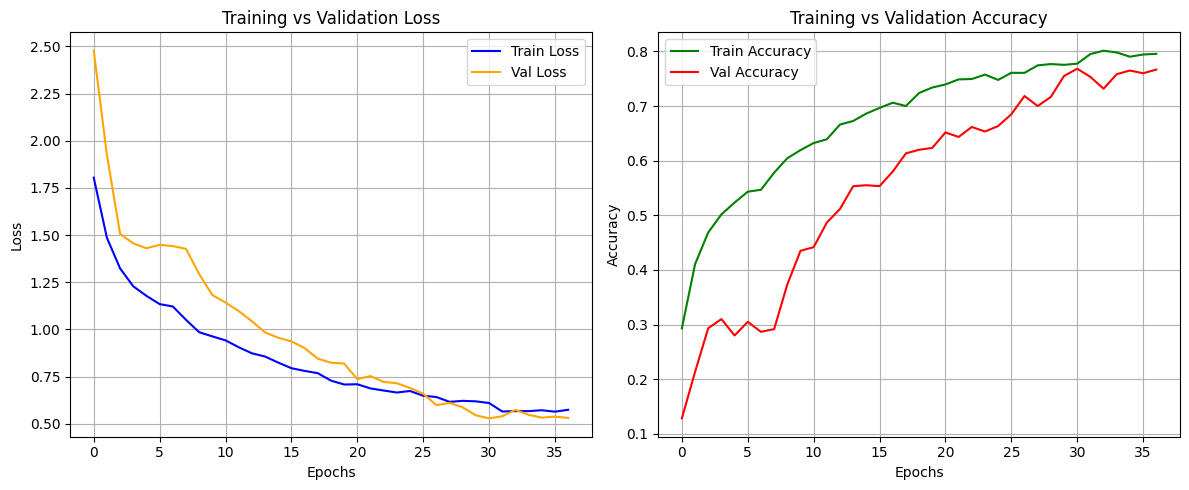

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Test Accuracy: 0.7683
Test F1-score: 0.7609


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# ===== TRAINING =====
history = enhanced_pipeline.train_enhanced_model(
    X_train=Xtrain,
    y_train=Ytrain,
    Xtest=Xtest,
    Ytest=Ytest,
    epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    patience_es=patience_es,
    patience_lr=patience_lr,
    min_delta=min_delta,
    checkpoint_path=checkpoint_path
)

# ===== PLOTS =====
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ===== TEST METRICS =====
y_pred_probs = enhanced_model.predict(Xtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Ytest, axis=1)

test_accuracy = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='weighted')  # weighted for multi-class

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-score: {test_f1:.4f}")


In [ ]:
# FLOPs counter for TF2 Keras models
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model: tf.keras.Model, batch_size: int = 1) -> int:
    """
    Returns the approximate number of floating-point operations (FLOPs)
    for a single forward pass of `batch_size` samples through `model`.
    Note: different profilers may count ops slightly differently.
    """
    # Make sure model is built (has defined input shape)
    if not model.built:
        # try to build with an example input
        input_shape = [batch_size] + list(model.input.shape[1:])
        model.build(input_shape)

    # Create a concrete function from the Keras model
    input_spec = tf.TensorSpec([batch_size] + list(model.input.shape[1:]), model.inputs[0].dtype)
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(input_spec)

    # Convert to a frozen graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # Import the graph_def into a new Graph and run the v1 profiler
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')

        with tf.compat.v1.Session(graph=graph) as sess:
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # profile the graph to get float ops
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                cmd='op',
                options=opts
            )
            if flops is None:
                return 0
            return flops.total_float_ops

# Example usage:
# Assuming `model` is your Keras model (already created and compiled)
flops = get_flops(enhanced_model, batch_size=1)
print(f"FLOPs: {flops:,}  ({flops/1e9:.6f} GFLOPs) ")
print(f"Parameters: {enhanced_model.count_params():,}")


FLOPs: 3,037,095  (0.003037 GFLOPs) 
Parameters: 21,423


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np

# Predictions
y_pred_probs = enhanced_model.predict(Xtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Ytest, axis=1)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("\nMODEL EVALUATION METRICS")
print("=" * 40)
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"F1-score   : {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

MODEL EVALUATION METRICS
Accuracy   : 0.7683
Precision  : 0.7705
Recall     : 0.7683
F1-score   : 0.7609

Classification Report:
              precision    recall  f1-score   support

       64QAM       0.41      0.37      0.39        81
        GMSK       0.96      0.74      0.84        73
       OTHER       1.00      1.00      1.00        70
        BPSK       0.68      0.89      0.77        61
       CPFSK       1.00      0.97      0.99        77
       16QAM       0.64      0.84      0.73        88
        GFSK       0.62      0.40      0.48        73
        QPSK       0.89      0.97      0.93        77

    accuracy                           0.77       600
   macro avg       0.78      0.77      0.77       600
weighted avg       0.77      0.77      0.76       600

Confusion Matrix:
 [[30  0  0 10  0 40  0  1]
 [ 1 54  0  0  0  0 18  0]
 [ 0  0 70  0  0  0  0  0]
 [ 0  0  0 54  0  0  0  7]
 [ 0  1  0  0 75  0  0  1]
 [ 0  0  0 14  0 74  0  0

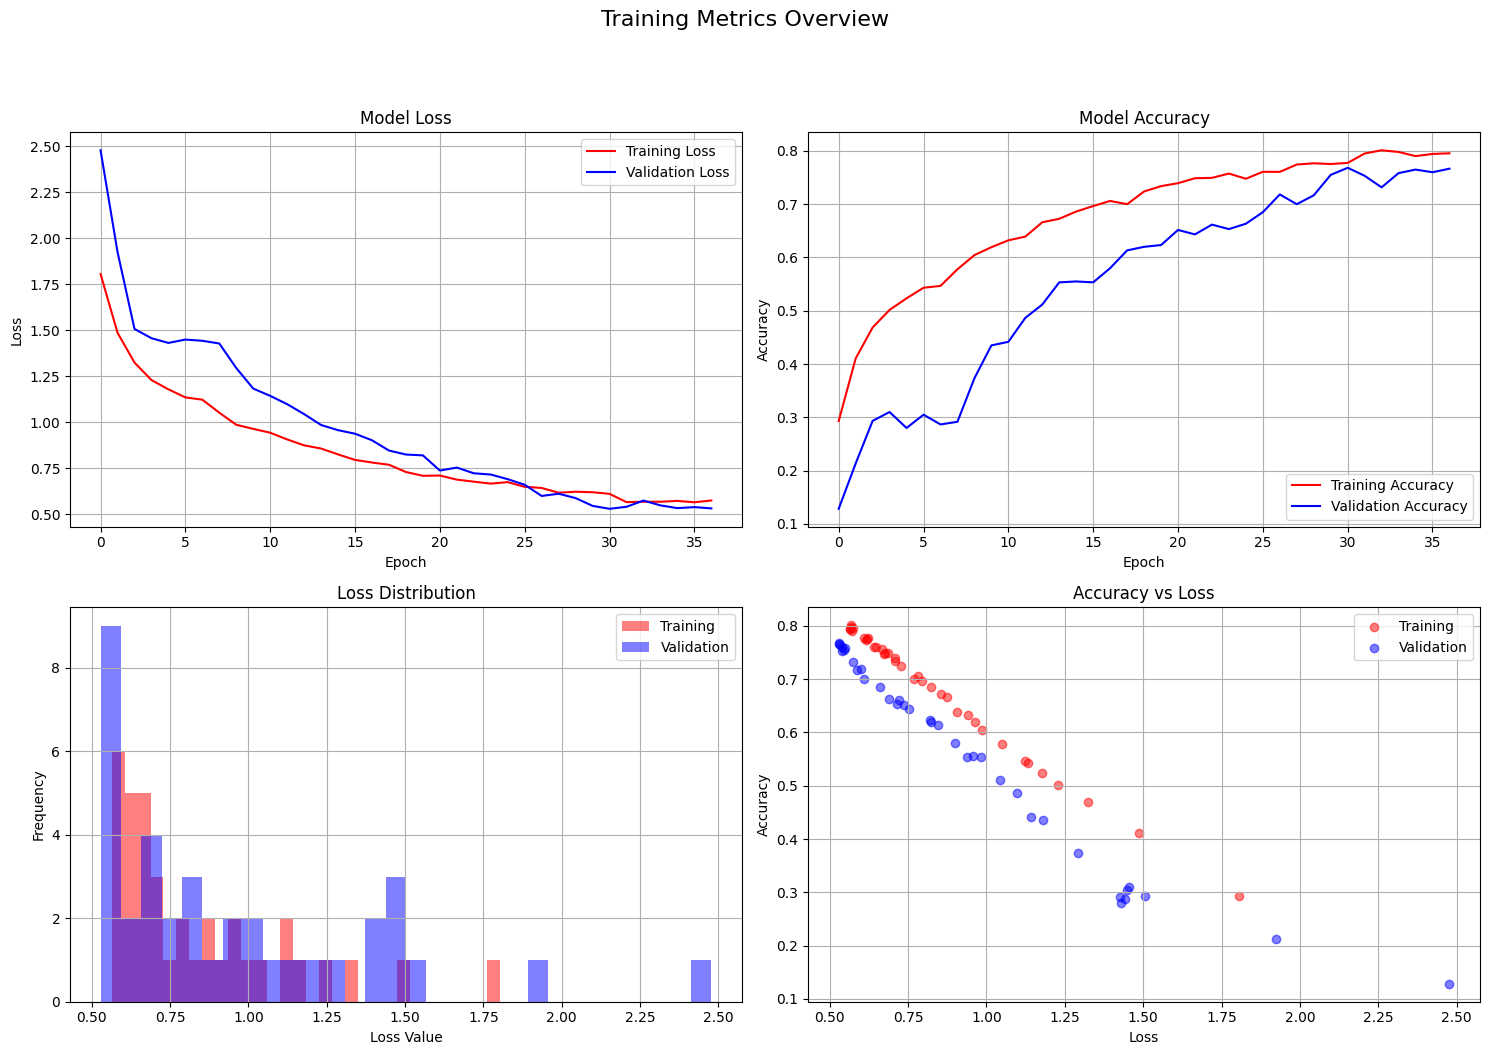


Final Training Metrics:
--------------------------------------------------
Final Training Loss: 0.5736
Final Validation Loss: 0.5306
Final Training Accuracy: 0.7956
Final Validation Accuracy: 0.7667

Model Improvement:
--------------------------------------------------
Loss Improvement: 1.2306
Accuracy Improvement: 0.5025


In [ ]:
enhanced_history = history

def plot_training_metrics(history_dict):
    """
    Plot comprehensive training metrics including loss, accuracy, and learning rate
    """
    metrics = ['loss', 'accuracy']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics Overview', fontsize=16, y=1.05)

    # Plot loss
    ax = axes[0, 0]
    ax.plot(history_dict['loss'], label='Training Loss', color='red')
    ax.plot(history_dict['val_loss'], label='Validation Loss', color='blue')
    ax.set_title('Model Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    ax.grid(True)

    # Plot accuracy
    ax = axes[0, 1]
    ax.plot(history_dict['accuracy'], label='Training Accuracy', color='red')
    ax.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='blue')
    ax.set_title('Model Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.grid(True)

    # Plot loss distribution
    ax = axes[1, 0]
    ax.hist(history_dict['loss'], bins=30, alpha=0.5, color='red', label='Training')
    ax.hist(history_dict['val_loss'], bins=30, alpha=0.5, color='blue', label='Validation')
    ax.set_title('Loss Distribution')
    ax.set_xlabel('Loss Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

    # Plot accuracy vs loss
    ax = axes[1, 1]
    ax.scatter(history_dict['loss'], history_dict['accuracy'],
              c='red', alpha=0.5, label='Training')
    ax.scatter(history_dict['val_loss'], history_dict['val_accuracy'],
              c='blue', alpha=0.5, label='Validation')
    ax.set_title('Accuracy vs Loss')
    ax.set_xlabel('Loss')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Metrics:")
    print("-" * 50)
    print(f"Final Training Loss: {history_dict['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history_dict['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history_dict['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history_dict['val_accuracy'][-1]:.4f}")

    # Calculate improvement
    print("\nModel Improvement:")
    print("-" * 50)
    print(f"Loss Improvement: {history_dict['loss'][0] - history_dict['loss'][-1]:.4f}")
    print(f"Accuracy Improvement: {history_dict['accuracy'][-1] - history_dict['accuracy'][0]:.4f}")

# Use the function after training
plot_training_metrics(enhanced_history.history)

Primary test path not found: C:\Users\Jehan_140826\Downloads\rfsc-dataset\Dataset_Deep_Radio\Dataset_Deep_Radio\testing_data
Trying alternative paths...
Found test data at: /content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/testing_data
🔍 COMPREHENSIVE TEST DATA EVALUATION
Using test data from: /content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/testing_data
🔄 Loading test data from separate test dataset...
Test data path: /content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/testing_data
📁 Found test classes: ['16QAM', '64QAM', 'BPSK', 'CPFSK', 'GFSK', 'GMSK', 'OTHER', 'QPSK']
  📊 16QAM: 125 samples
  📊 64QAM: 125 samples
  📊 BPSK: 125 samples
  📊 CPFSK: 125 samples
  📊 GFSK: 125 samples
  📊 GMSK: 125 samples
  📊 OTHER: 125 samples
  📊 QPSK: 125 samples

✅ Test data loaded successfully!
   • Total test samples: 1000
   • Input shape: (1000, 28, 28, 2)
   • Label shape: (1000, 8)
   • Number of classes: 8

Using optimized

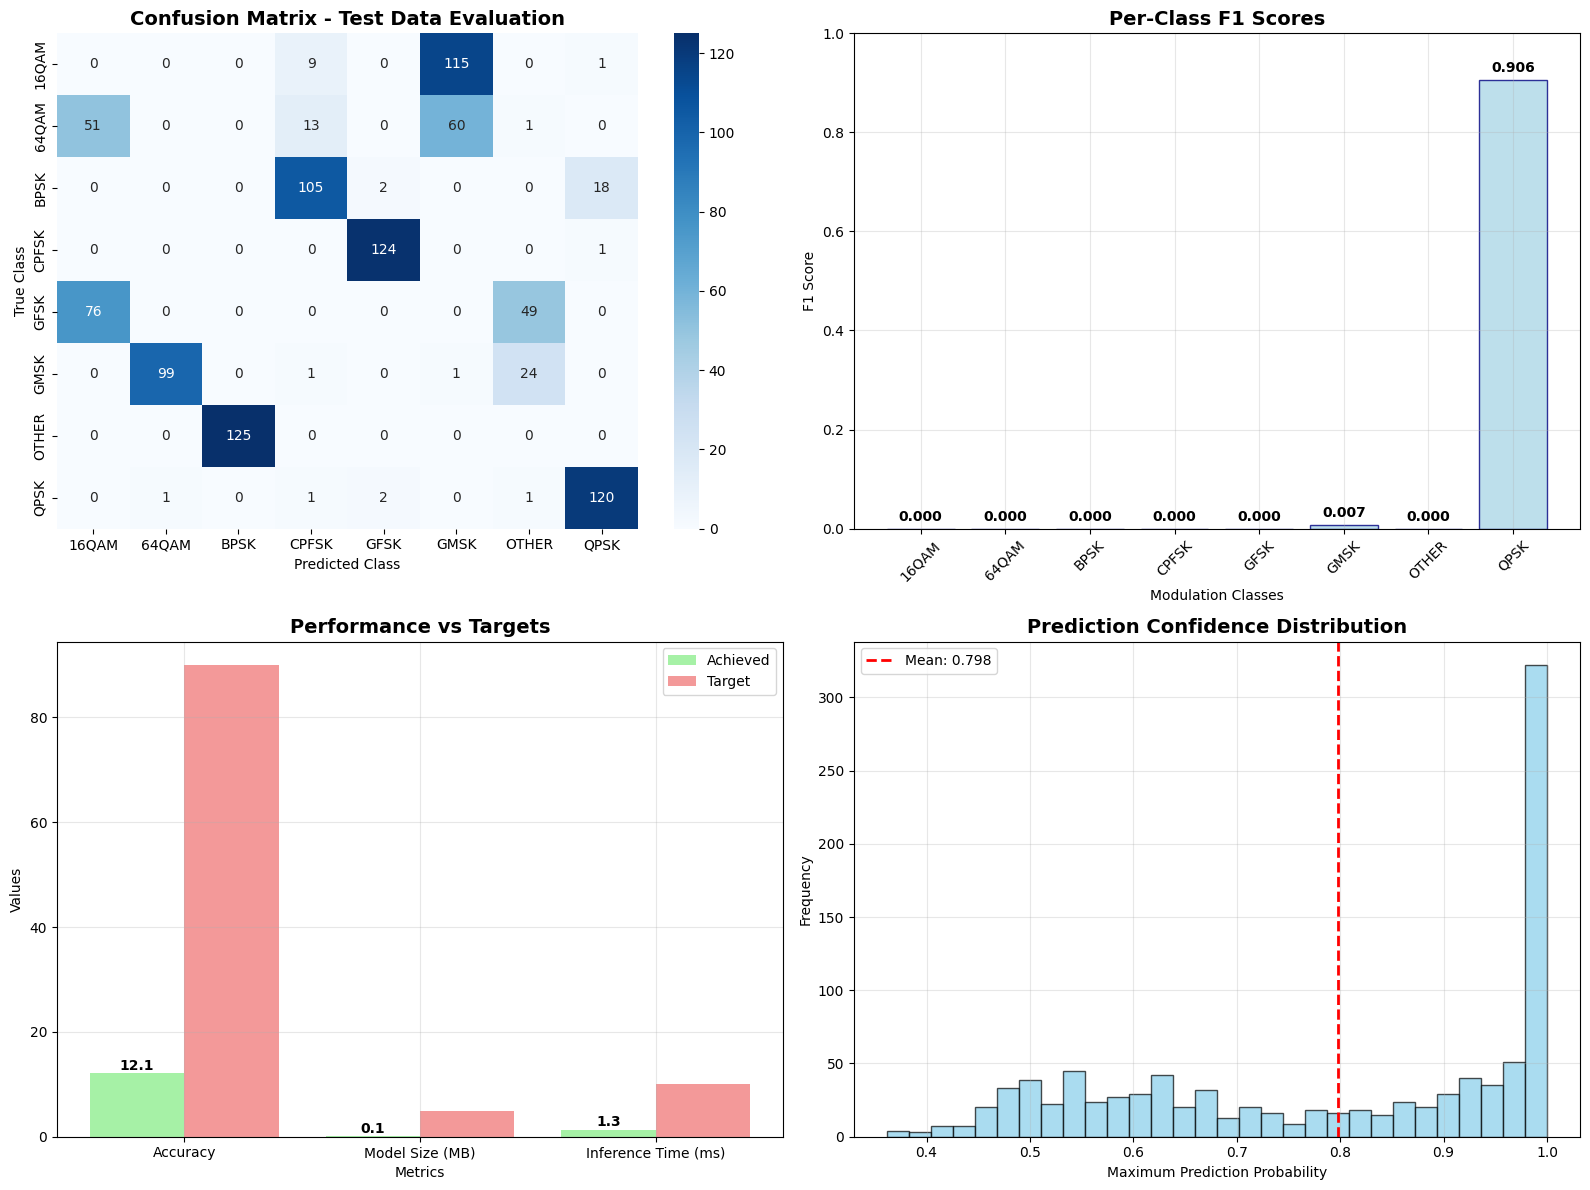


🎯 PERFORMANCE ANALYSIS & RECOMMENDATIONS
📈 TARGET ACHIEVEMENT STATUS:
----------------------------------------
   • Accuracy Target (≥90%): 12.10% - ❌ NEEDS IMPROVEMENT
   • Model Size Target (≤5MB): 0.08MB - ✅ ACHIEVED
   • Speed Target (≤10ms): 1.32ms - ✅ ACHIEVED

 CLASS PERFORMANCE ANALYSIS:
----------------------------------------
   • Average F1 Score: 0.114 ± 0.299
   • Performance Range: 0.000 - 0.906
   • Classes needing attention: 16QAM, 64QAM, BPSK, CPFSK, GFSK, GMSK, OTHER

 PREDICTION CONFIDENCE ANALYSIS:
----------------------------------------
   • Average Confidence: 0.798
   • Low Confidence Predictions (<0.8): 439/1000 (43.9%)

 RECOMMENDATIONS:
----------------------------------------
    TO IMPROVE ACCURACY:
     • Increase model capacity (alpha parameter)
     • Add more diverse data augmentation
     • Try ensemble methods
     • Fine-tune on problematic classes
    FOR POOR-PERFORMING CLASSES:
     • Apply class-specific data augmentation
     • Collect more sam

In [ ]:
class TestDataEvaluator:
    """
    Comprehensive evaluation using separate test dataset.
    Loads test data from the same folder structure as training data.
    """

    def __init__(self, test_data_path):
        self.test_data_path = test_data_path
        self.test_classes = None
        self.X_test = None
        self.y_test = None
        self.class_names = None

    def load_test_data(self):
        """Load test data from the specified path with same structure as training data."""
        print("🔄 Loading test data from separate test dataset...")
        print(f"Test data path: {self.test_data_path}")

        if not os.path.exists(self.test_data_path):
            print(f"❌ Test data path not found: {self.test_data_path}")
            return False

        # Get available classes from test data folders
        self.test_classes = [d for d in os.listdir(self.test_data_path)
                            if os.path.isdir(os.path.join(self.test_data_path, d))]
        self.test_classes.sort()  # Ensure consistent ordering

        print(f"📁 Found test classes: {self.test_classes}")

        samples = []
        labels = []
        sample_names = []
        class_distribution = {}

        for class_idx, class_name in enumerate(self.test_classes):
            class_path = os.path.join(self.test_data_path, class_name)
            npy_files = glob.glob(os.path.join(class_path, '*.npy'))

            class_samples = 0
            for npy_file in npy_files:
                try:
                    # Load I/Q samples
                    iq_samples = np.load(npy_file)

                    # Convert to real/imaginary format
                    real = np.real(iq_samples)
                    imag = np.imag(iq_samples)

                    # Interleave real and imaginary parts
                    iq_interleaved = np.ravel(np.column_stack((real, imag)))

                    # Take first 1568 samples (28x28x2 = 1568)
                    iq_trimmed = iq_interleaved[:1568]

                    # Reshape to (28, 28, 2)
                    iq_reshaped = iq_trimmed.reshape(28, 28, 2)

                    samples.append(iq_reshaped)

                    # Create one-hot label
                    label = np.zeros(len(self.test_classes))
                    label[class_idx] = 1.0
                    labels.append(label)

                    sample_names.append(os.path.basename(npy_file))
                    class_samples += 1

                except Exception as e:
                    print(f"⚠️ Error loading {npy_file}: {str(e)}")
                    continue

            class_distribution[class_name] = class_samples
            print(f"  📊 {class_name}: {class_samples} samples")

        self.X_test = np.array(samples, dtype=np.float32)
        self.y_test = np.array(labels, dtype=np.float32)
        self.class_names = self.test_classes

        print(f"\n✅ Test data loaded successfully!")
        print(f"   • Total test samples: {len(self.X_test)}")
        print(f"   • Input shape: {self.X_test.shape}")
        print(f"   • Label shape: {self.y_test.shape}")
        print(f"   • Number of classes: {len(self.test_classes)}")

        return True

    def evaluate_model(self, model, detailed_analysis=True):
        """
        Comprehensive model evaluation on test data.
        """
        if self.X_test is None:
            print("❌ No test data loaded. Please run load_test_data() first.")
            return None

        print("\n🔍 EVALUATING MODEL ON SEPARATE TEST DATASET")
        print("=" * 60)

        # Measure inference time
        print("⏱️ Measuring inference performance...")
        start_time = time.time()
        predictions = model.predict(self.X_test, verbose=1)
        total_inference_time = time.time() - start_time
        avg_inference_time_ms = (total_inference_time / len(self.X_test)) * 1000

        # Calculate predictions and ground truth
        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(self.y_test, axis=1)

        # Overall accuracy
        accuracy = np.mean(y_pred == y_true)

        # Model size
        model_size_mb = (model.count_params() * 4) / (1024 * 1024)

        print(f"\n OVERALL PERFORMANCE METRICS:")
        print("-" * 40)
        print(f"   • Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"   • Model Size: {model_size_mb:.2f} MB")
        print(f"   • Total Inference Time: {total_inference_time:.2f} seconds")
        print(f"   • Average Inference Time: {avg_inference_time_ms:.2f} ms per sample")
        print(f"   • Throughput: {len(self.X_test)/total_inference_time:.1f} samples/second")
        print(f"   • Total Parameters: {model.count_params():,}")

        # Detailed per-class analysis
        if detailed_analysis:
            print(f"\n DETAILED CLASSIFICATION REPORT:")
            print("-" * 50)
            print(classification_report(y_true, y_pred, target_names=self.class_names, digits=4))

            # Per-class metrics
            precision, recall, f1, support = precision_recall_fscore_support(
                y_true, y_pred, average=None
            )

            print(f"\n PER-CLASS PERFORMANCE SUMMARY:")
            print("-" * 50)
            for i, class_name in enumerate(self.class_names):
                print(f"   {class_name:>8s}: Precision={precision[i]:.3f}, "
                      f"Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}")

            # Identify best and worst performing classes
            best_class_idx = np.argmax(f1)
            worst_class_idx = np.argmin(f1)

            print(f"\n Best Performing Class: {self.class_names[best_class_idx]} (F1={f1[best_class_idx]:.3f})")
            print(f" Needs Attention: {self.class_names[worst_class_idx]} (F1={f1[worst_class_idx]:.3f})")

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        results = {
            'accuracy': accuracy,
            'model_size_mb': model_size_mb,
            'inference_time_ms': avg_inference_time_ms,
            'total_inference_time': total_inference_time,
            'throughput': len(self.X_test)/total_inference_time,
            'confusion_matrix': cm,
            'predictions': predictions,
            'y_true': y_true,
            'y_pred': y_pred,
            'precision': precision if detailed_analysis else None,
            'recall': recall if detailed_analysis else None,
            'f1_score': f1 if detailed_analysis else None,
            'support': support if detailed_analysis else None,
            'class_names': self.class_names
        }

        return results

    def create_visualization(self, results, save_plots=True):
        """
        Create comprehensive visualizations of test results.
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Confusion Matrix
        sns.heatmap(results['confusion_matrix'],
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'],
                   annot=True, fmt='d',
                   cmap='Blues',
                   ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix - Test Data Evaluation', fontsize=14, fontweight='bold')
        axes[0,0].set_xlabel('Predicted Class')
        axes[0,0].set_ylabel('True Class')

        # 2. Per-class F1 Scores
        if results['f1_score'] is not None:
            bars = axes[0,1].bar(results['class_names'], results['f1_score'],
                               color='lightblue', alpha=0.8, edgecolor='navy')
            axes[0,1].set_title('Per-Class F1 Scores', fontsize=14, fontweight='bold')
            axes[0,1].set_xlabel('Modulation Classes')
            axes[0,1].set_ylabel('F1 Score')
            axes[0,1].set_ylim(0, 1)
            axes[0,1].tick_params(axis='x', rotation=45)
            axes[0,1].grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, score in zip(bars, results['f1_score']):
                height = bar.get_height()
                axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

        # 3. Performance Metrics Comparison
        metrics = ['Accuracy', 'Model Size (MB)', 'Inference Time (ms)']
        values = [results['accuracy']*100, results['model_size_mb'], results['inference_time_ms']]
        targets = [90, 5, 10]  # Target values

        x_pos = np.arange(len(metrics))
        bars1 = axes[1,0].bar(x_pos - 0.2, values, 0.4, label='Achieved', color='lightgreen', alpha=0.8)
        bars2 = axes[1,0].bar(x_pos + 0.2, targets, 0.4, label='Target', color='lightcoral', alpha=0.8)

        axes[1,0].set_title('Performance vs Targets', fontsize=14, fontweight='bold')
        axes[1,0].set_xlabel('Metrics')
        axes[1,0].set_ylabel('Values')
        axes[1,0].set_xticks(x_pos)
        axes[1,0].set_xticklabels(metrics)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Add value labels
        for bar, value in zip(bars1, values):
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                          f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

        # 4. Prediction Confidence Distribution
        max_probs = np.max(results['predictions'], axis=1)
        axes[1,1].hist(max_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1,1].axvline(np.mean(max_probs), color='red', linestyle='--', linewidth=2,
                         label=f'Mean: {np.mean(max_probs):.3f}')
        axes[1,1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Maximum Prediction Probability')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_plots:
            plt.savefig('test_evaluation_results.png', dpi=300, bbox_inches='tight')
            print("📊 Visualization saved as 'test_evaluation_results.png'")

        plt.show()

        return fig

    def performance_analysis(self, results):
        """
        Provide detailed performance analysis and recommendations.
        """
        print("\n🎯 PERFORMANCE ANALYSIS & RECOMMENDATIONS")
        print("=" * 60)

        # Target achievement analysis
        accuracy_target = 0.90
        size_target = 5.0  # MB
        speed_target = 10.0  # ms

        print(f"📈 TARGET ACHIEVEMENT STATUS:")
        print("-" * 40)

        accuracy_status = "✅ ACHIEVED" if results['accuracy'] >= accuracy_target else "⚠️ CLOSE" if results['accuracy'] >= 0.85 else "❌ NEEDS IMPROVEMENT"
        size_status = "✅ ACHIEVED" if results['model_size_mb'] <= size_target else "❌ EXCEEDED"
        speed_status = "✅ ACHIEVED" if results['inference_time_ms'] <= speed_target else "❌ EXCEEDED"

        print(f"   • Accuracy Target (≥90%): {results['accuracy']*100:.2f}% - {accuracy_status}")
        print(f"   • Model Size Target (≤5MB): {results['model_size_mb']:.2f}MB - {size_status}")
        print(f"   • Speed Target (≤10ms): {results['inference_time_ms']:.2f}ms - {speed_status}")

        # Class-wise performance analysis
        if results['f1_score'] is not None:
            print(f"\n CLASS PERFORMANCE ANALYSIS:")
            print("-" * 40)

            avg_f1 = np.mean(results['f1_score'])
            std_f1 = np.std(results['f1_score'])

            print(f"   • Average F1 Score: {avg_f1:.3f} ± {std_f1:.3f}")
            print(f"   • Performance Range: {np.min(results['f1_score']):.3f} - {np.max(results['f1_score']):.3f}")

            # Identify problematic classes
            poor_classes = [results['class_names'][i] for i, f1 in enumerate(results['f1_score']) if f1 < 0.8]
            if poor_classes:
                print(f"   • Classes needing attention: {', '.join(poor_classes)}")
            else:
                print(f"   • All classes performing well (F1 > 0.8)")

        # Confidence analysis
        confidence_scores = np.max(results['predictions'], axis=1)
        low_confidence = np.sum(confidence_scores < 0.8)

        print(f"\n PREDICTION CONFIDENCE ANALYSIS:")
        print("-" * 40)
        print(f"   • Average Confidence: {np.mean(confidence_scores):.3f}")
        print(f"   • Low Confidence Predictions (<0.8): {low_confidence}/{len(confidence_scores)} ({low_confidence/len(confidence_scores)*100:.1f}%)")

        # Recommendations
        print(f"\n RECOMMENDATIONS:")
        print("-" * 40)

        if results['accuracy'] < 0.90:
            print("    TO IMPROVE ACCURACY:")
            print("     • Increase model capacity (alpha parameter)")
            print("     • Add more diverse data augmentation")
            print("     • Try ensemble methods")
            print("     • Fine-tune on problematic classes")

        if results['model_size_mb'] > 5.0:
            print("    TO REDUCE MODEL SIZE:")
            print("     • Reduce alpha parameter (width multiplier)")
            print("     • Apply model pruning")
            print("     • Use more aggressive quantization")

        if results['inference_time_ms'] > 10.0:
            print("    TO IMPROVE SPEED:")
            print("     • Reduce model complexity")
            print("     • Optimize batch size for your hardware")
            print("     • Consider TensorFlow Lite with quantization")

        if poor_classes:
            print("    FOR POOR-PERFORMING CLASSES:")
            print("     • Apply class-specific data augmentation")
            print("     • Collect more samples for these classes")
            print("     • Use focal loss or class weighting")

# Set up test data path (Update this to your actual test data path)
TEST_DATA_PATH = r"C:\Users\Jehan_140826\Downloads\rfsc-dataset\Dataset_Deep_Radio\Dataset_Deep_Radio\testing_data"

# Alternative paths if the above doesn't work
alternative_paths = [
    "/content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/testing_data",
    "testing_data",  # If in current directory
    "./testing_data"
]

# Try to find the correct path
test_path_found = None
if os.path.exists(TEST_DATA_PATH):
    test_path_found = TEST_DATA_PATH
else:
    print(f"Primary test path not found: {TEST_DATA_PATH}")
    print("Trying alternative paths...")
    for alt_path in alternative_paths:
        if os.path.exists(alt_path):
            test_path_found = alt_path
            print(f"Found test data at: {alt_path}")
            break

if test_path_found:
    print(f"🔍 COMPREHENSIVE TEST DATA EVALUATION")
    print("=" * 60)
    print(f"Using test data from: {test_path_found}")

    # Initialize evaluator
    evaluator = TestDataEvaluator(test_path_found)

    # Load test data
    if evaluator.load_test_data():
        # Ensure model is available
        if 'enhanced_model' in globals():
            print(f"\nUsing optimized model for evaluation...")
            test_results = evaluator.evaluate_model(enhanced_model, detailed_analysis=True)
        elif 'enhanced_model' in globals():
            print(f"\nUsing Model 4 for evaluation...")
            test_results = evaluator.evaluate_model(enhanced_model, detailed_analysis=True)
        else:
            print(" No trained model found. Please train a model first.")
            test_results = None

        if test_results:
            # Create visualizations
            evaluator.create_visualization(test_results, save_plots=True)

            # Performance analysis
            evaluator.performance_analysis(test_results)

            # Summary
            print(f"\n🎉 TEST EVALUATION COMPLETE!")
            print("=" * 60)
            print(f" Evaluated on {len(evaluator.X_test)} test samples")
            print(f" Test accuracy: {test_results['accuracy']*100:.2f}%")
            print(f" Model size: {test_results['model_size_mb']:.2f} MB")
            print(f" Inference speed: {test_results['inference_time_ms']:.2f} ms/sample")
            print("=" * 60)

        else:
            print(" Test evaluation failed.")

    else:
        print(" Failed to load test data.")

else:
    print(" Test data path not found!")


Run 1: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.99
Epoch 1/60
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1921 - loss: 1.9924
Epoch 1: val_loss improved from inf to 2.15779, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.1928 - loss: 1.9909 - val_accuracy: 0.1250 - val_loss: 2.1578 - learning_rate: 5.0000e-05
Epoch 2/60
217/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3443 - loss: 1.6352
Epoch 2: val_loss did not improve from 2.15779
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3446 - loss: 1.6333 - val_accuracy: 0.1700 - val_loss: 2.3664 - learning_rate: 5.0000e-05
Epoch 3/60
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3838 - loss: 1.4652
Epoch 3: val_loss improved from 2.15779 to 1.72305, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3842 - loss: 1.4645 - val_accuracy: 0.2667 - val_loss: 1.7230 - learning_rate: 5.0000e-0

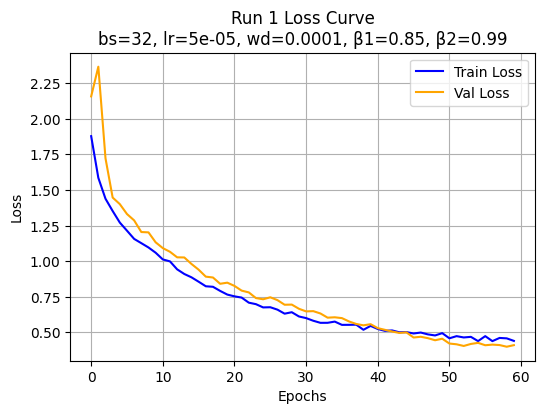

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
Test Accuracy: 0.8433, F1-score: 0.8385
Run 2: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.99
Epoch 1/60
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1172 - loss: 2.1226
Epoch 1: val_loss improved from inf to 2.15288, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.1184 - loss: 2.1206 - val_accuracy: 0.1417 - val_loss: 2.1529 - learning_rate: 5.0000e-05
Epoch 2/60
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3142 - loss: 1.7707
Epoch 2: val_loss did not improve from 2.15288
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3144 - loss: 1.7700 - val_accuracy: 0.1417 - val_loss: 2.2922 - learning_rate: 5.0000e-05
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3751 - loss: 1.5636
Epoch 3: val_loss improved from 2.15288 to 1.72193, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3752 - lo

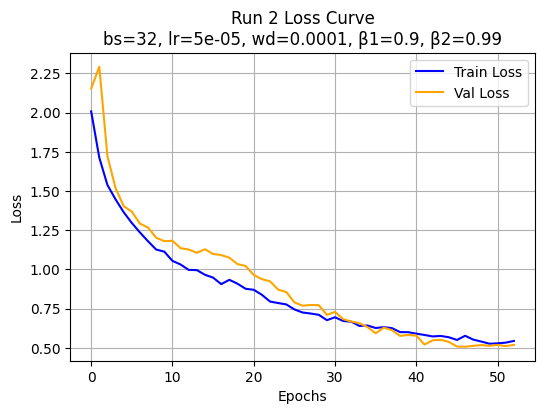

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step
Test Accuracy: 0.7917, F1-score: 0.7819
Run 3: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.99
Epoch 1/60
219/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2341 - loss: 1.9659
Epoch 1: val_loss improved from inf to 2.14882, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.2357 - loss: 1.9629 - val_accuracy: 0.1417 - val_loss: 2.1488 - learning_rate: 5.0000e-05
Epoch 2/60
219/225 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3498 - loss: 1.6807
Epoch 2: val_loss improved from 2.14882 to 2.13276, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3505 - loss: 1.6790 - val_accuracy: 0.1417 - val_loss: 2.1328 - learning_rate: 5.0000e-05
Epoch 3/60
217/225 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4175 - loss: 1.5200
Epoch 3: val_loss improved from 2.13276 to 1.56629, saving model to enhanced_best_model.keras
225/225 ━━━━━━━

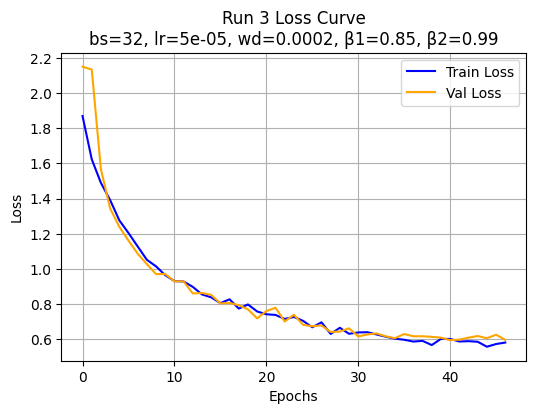

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step
Test Accuracy: 0.7067, F1-score: 0.6986
Run 4: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.99
Epoch 1/60
218/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1907 - loss: 1.9884
Epoch 1: val_loss improved from inf to 2.15126, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.1930 - loss: 1.9847 - val_accuracy: 0.1417 - val_loss: 2.1513 - learning_rate: 5.0000e-05
Epoch 2/60
217/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3516 - loss: 1.6832
Epoch 2: val_loss improved from 2.15126 to 2.01494, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3521 - loss: 1.6818 - val_accuracy: 0.1533 - val_loss: 2.0149 - learning_rate: 5.0000e-05
Epoch 3/60
219/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4137 - loss: 1.5466
Epoch 3: val_loss improved from 2.01494 to 1.56611, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━

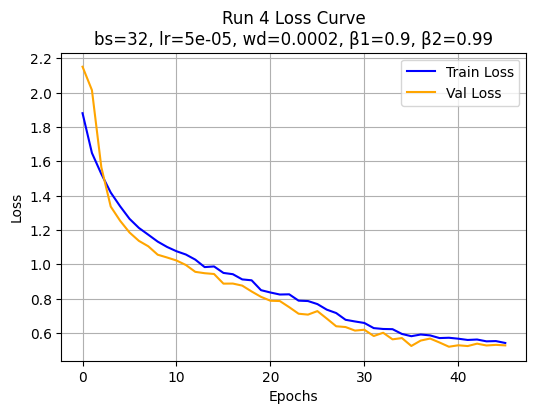

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Test Accuracy: 0.7533, F1-score: 0.7470
Run 5: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.99
Epoch 1/60
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2552 - loss: 1.9281
Epoch 1: val_loss improved from inf to 2.16129, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.2559 - loss: 1.9267 - val_accuracy: 0.1183 - val_loss: 2.1613 - learning_rate: 5.0000e-05
Epoch 2/60
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3940 - loss: 1.5649
Epoch 2: val_loss did not improve from 2.16129
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3944 - loss: 1.5635 - val_accuracy: 0.1517 - val_loss: 2.2748 - learning_rate: 5.0000e-05
Epoch 3/60
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4531 - loss: 1.3702
Epoch 3: val_loss improved from 2.16129 to 1.55811, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4532 - l

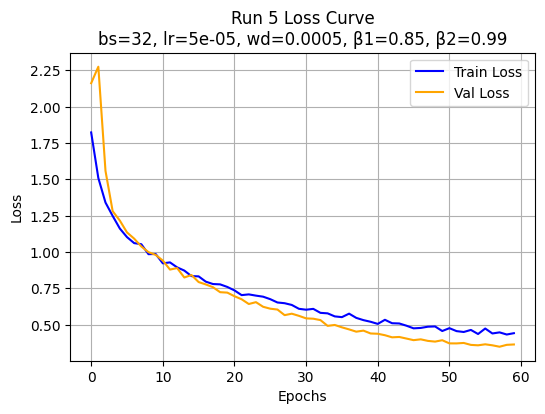

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
Test Accuracy: 0.9033, F1-score: 0.9023
Run 6: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.9, beta2=0.99
Epoch 1/60
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2316 - loss: 1.9670
Epoch 1: val_loss improved from inf to 2.19860, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.2327 - loss: 1.9650 - val_accuracy: 0.1200 - val_loss: 2.1986 - learning_rate: 5.0000e-05
Epoch 2/60
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3610 - loss: 1.7053
Epoch 2: val_loss did not improve from 2.19860
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3612 - loss: 1.7042 - val_accuracy: 0.2583 - val_loss: 2.2263 - learning_rate: 5.0000e-05
Epoch 3/60
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4094 - loss: 1.5434
Epoch 3: val_loss improved from 2.19860 to 1.57831, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4096 - lo

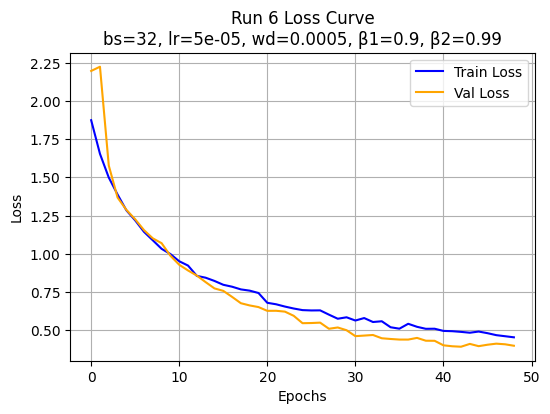

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step
Test Accuracy: 0.8417, F1-score: 0.8400
Run 7: batch_size=32, lr=0.0001, weight_decay=0.0001, beta1=0.85, beta2=0.99
Epoch 1/60
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2197 - loss: 1.9732
Epoch 1: val_loss improved from inf to 2.40633, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.2208 - loss: 1.9709 - val_accuracy: 0.1417 - val_loss: 2.4063 - learning_rate: 1.0000e-04
Epoch 2/60
217/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4096 - loss: 1.5335
Epoch 2: val_loss did not improve from 2.40633
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4107 - loss: 1.5301 - val_accuracy: 0.1417 - val_loss: 2.6095 - learning_rate: 1.0000e-04
Epoch 3/60
217/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4877 - loss: 1.2783
Epoch 3: val_loss improved from 2.40633 to 1.30235, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4882 -

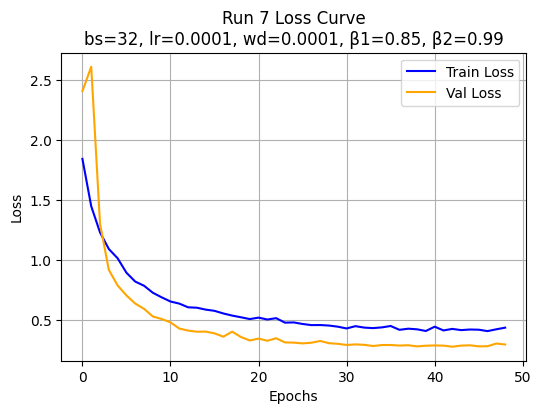

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
Test Accuracy: 0.9300, F1-score: 0.9297
Run 8: batch_size=32, lr=0.0001, weight_decay=0.0001, beta1=0.9, beta2=0.99
Epoch 1/60
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2400 - loss: 1.8882
Epoch 1: val_loss improved from inf to 2.66859, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.2406 - loss: 1.8870 - val_accuracy: 0.1250 - val_loss: 2.6686 - learning_rate: 1.0000e-04
Epoch 2/60
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4116 - loss: 1.4689
Epoch 2: val_loss did not improve from 2.66859
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4121 - loss: 1.4674 - val_accuracy: 0.1450 - val_loss: 3.2328 - learning_rate: 1.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4717 - loss: 1.2877
Epoch 3: val_loss improved from 2.66859 to 1.71772, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4718 - l

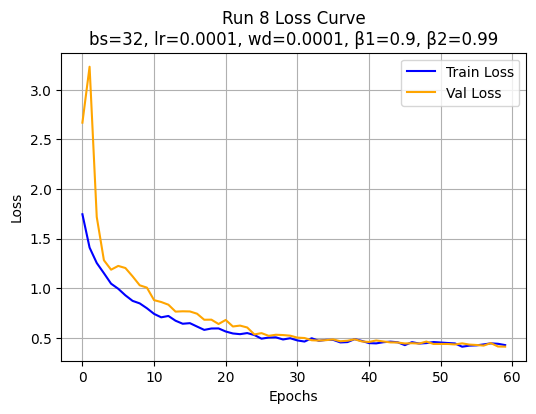

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
Test Accuracy: 0.8333, F1-score: 0.8291
Run 9: batch_size=32, lr=0.0001, weight_decay=0.0002, beta1=0.85, beta2=0.99
Epoch 1/60
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2149 - loss: 1.9544
Epoch 1: val_loss improved from inf to 2.29462, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.2155 - loss: 1.9531 - val_accuracy: 0.1133 - val_loss: 2.2946 - learning_rate: 1.0000e-04
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4234 - loss: 1.4801
Epoch 2: val_loss did not improve from 2.29462
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4236 - loss: 1.4797 - val_accuracy: 0.2583 - val_loss: 2.3859 - learning_rate: 1.0000e-04
Epoch 3/60
219/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4987 - loss: 1.2431
Epoch 3: val_loss improved from 2.29462 to 1.30416, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4993 -

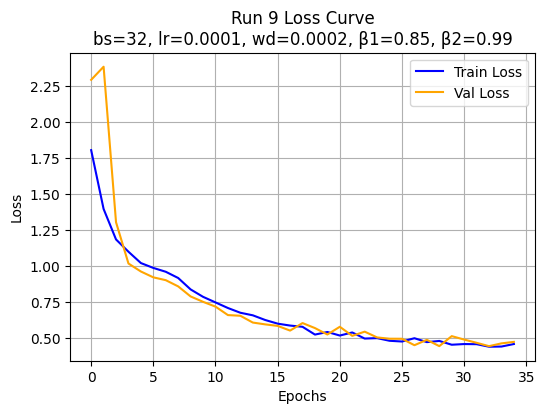

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
Test Accuracy: 0.8100, F1-score: 0.8051
Run 10: batch_size=32, lr=0.0001, weight_decay=0.0002, beta1=0.9, beta2=0.99
Epoch 1/60
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2784 - loss: 1.8767
Epoch 1: val_loss improved from inf to 2.32423, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.2800 - loss: 1.8729 - val_accuracy: 0.1133 - val_loss: 2.3242 - learning_rate: 1.0000e-04
Epoch 2/60
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4439 - loss: 1.4457
Epoch 2: val_loss improved from 2.32423 to 2.04523, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4444 - loss: 1.4441 - val_accuracy: 0.2550 - val_loss: 2.0452 - learning_rate: 1.0000e-04
Epoch 3/60
220/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4993 - loss: 1.2708
Epoch 3: val_loss improved from 2.04523 to 1.26272, saving model to enhanced_best_model.keras
225/225 ━━━━━━━

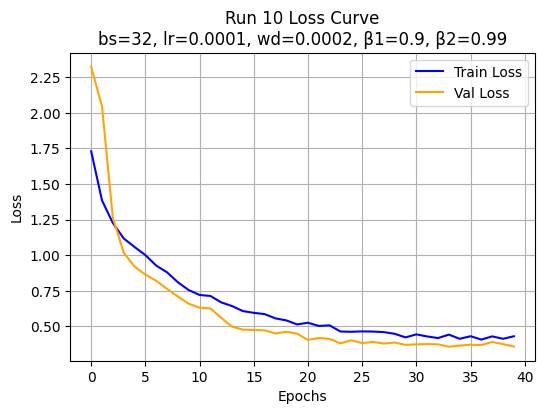

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
Test Accuracy: 0.8633, F1-score: 0.8616
Run 11: batch_size=32, lr=0.0001, weight_decay=0.0005, beta1=0.85, beta2=0.99
Epoch 1/60
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1816 - loss: 1.9459
Epoch 1: val_loss improved from inf to 2.37549, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.1823 - loss: 1.9446 - val_accuracy: 0.1417 - val_loss: 2.3755 - learning_rate: 1.0000e-04
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3661 - loss: 1.5152
Epoch 2: val_loss did not improve from 2.37549
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3662 - loss: 1.5150 - val_accuracy: 0.1433 - val_loss: 2.8344 - learning_rate: 1.0000e-04
Epoch 3/60
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4533 - loss: 1.3076
Epoch 3: val_loss improved from 2.37549 to 1.32558, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4537 -

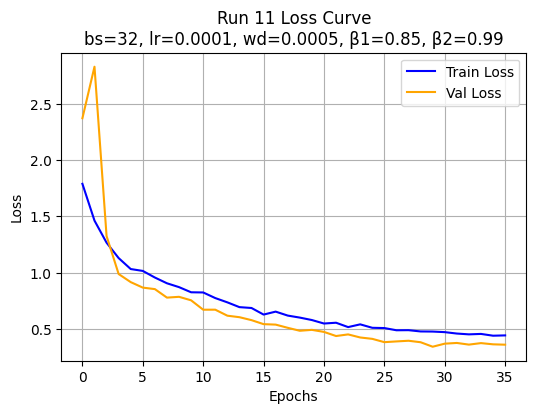

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
Test Accuracy: 0.8850, F1-score: 0.8833
Run 12: batch_size=32, lr=0.0001, weight_decay=0.0005, beta1=0.9, beta2=0.99
Epoch 1/60
218/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2342 - loss: 1.9374
Epoch 1: val_loss improved from inf to 2.26382, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.2372 - loss: 1.9312 - val_accuracy: 0.1183 - val_loss: 2.2638 - learning_rate: 1.0000e-04
Epoch 2/60
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4704 - loss: 1.3706
Epoch 2: val_loss did not improve from 2.26382
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4706 - loss: 1.3695 - val_accuracy: 0.2400 - val_loss: 2.6351 - learning_rate: 1.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5267 - loss: 1.1472
Epoch 3: val_loss improved from 2.26382 to 1.40258, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5267 - 

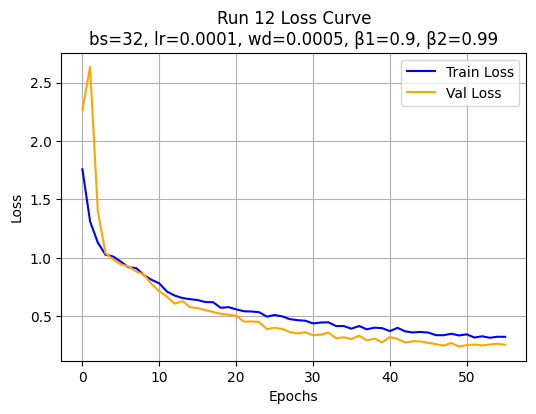

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Test Accuracy: 0.9533, F1-score: 0.9533
Run 13: batch_size=32, lr=0.0002, weight_decay=0.0001, beta1=0.85, beta2=0.99
Epoch 1/60
218/225 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3204 - loss: 1.8208
Epoch 1: val_loss improved from inf to 2.62570, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.3235 - loss: 1.8125 - val_accuracy: 0.1250 - val_loss: 2.6257 - learning_rate: 2.0000e-04
Epoch 2/60
216/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5020 - loss: 1.2277
Epoch 2: val_loss did not improve from 2.62570
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5027 - loss: 1.2249 - val_accuracy: 0.2583 - val_loss: 2.9998 - learning_rate: 2.0000e-04
Epoch 3/60
217/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5512 - loss: 1.0401
Epoch 3: val_loss improved from 2.62570 to 1.27709, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5514 -

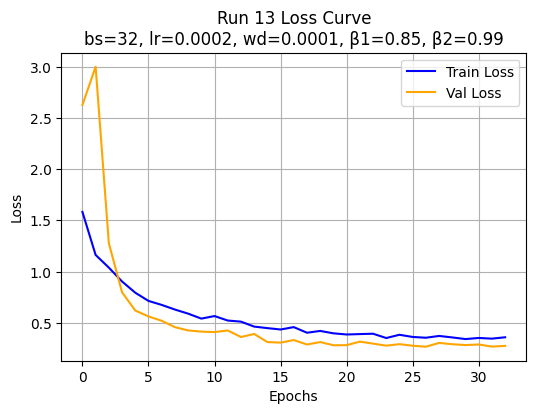

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Test Accuracy: 0.9167, F1-score: 0.9158
Run 14: batch_size=32, lr=0.0002, weight_decay=0.0001, beta1=0.9, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3125 - loss: 1.7350
Epoch 1: val_loss improved from inf to 3.10492, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.3129 - loss: 1.7341 - val_accuracy: 0.1183 - val_loss: 3.1049 - learning_rate: 2.0000e-04
Epoch 2/60
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5150 - loss: 1.1806
Epoch 2: val_loss did not improve from 3.10492
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5153 - loss: 1.1801 - val_accuracy: 0.2583 - val_loss: 3.3982 - learning_rate: 2.0000e-04
Epoch 3/60
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5668 - loss: 1.0236
Epoch 3: val_loss improved from 3.10492 to 1.45813, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5669 - 

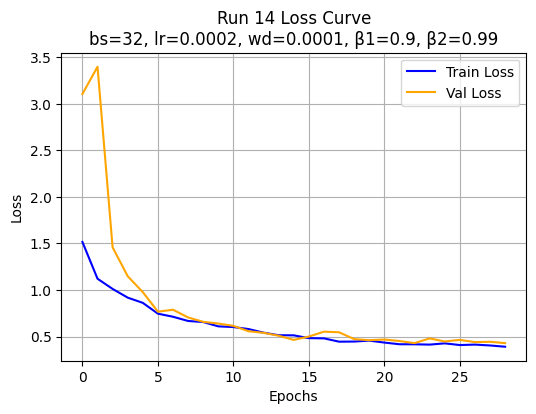

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step
Test Accuracy: 0.8167, F1-score: 0.8128
Run 15: batch_size=32, lr=0.0002, weight_decay=0.0002, beta1=0.85, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3275 - loss: 1.7521
Epoch 1: val_loss improved from inf to 2.55854, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.3279 - loss: 1.7511 - val_accuracy: 0.1183 - val_loss: 2.5585 - learning_rate: 2.0000e-04
Epoch 2/60
218/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5198 - loss: 1.2002
Epoch 2: val_loss did not improve from 2.55854
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5206 - loss: 1.1979 - val_accuracy: 0.2800 - val_loss: 2.7386 - learning_rate: 2.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5770 - loss: 1.0058
Epoch 3: val_loss improved from 2.55854 to 1.26611, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5770 

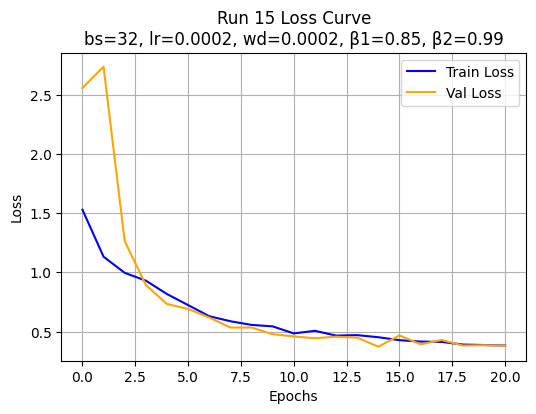

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
Test Accuracy: 0.8617, F1-score: 0.8598
Run 16: batch_size=32, lr=0.0002, weight_decay=0.0002, beta1=0.9, beta2=0.99
Epoch 1/60
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2643 - loss: 1.7696
Epoch 1: val_loss improved from inf to 2.61840, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.2653 - loss: 1.7672 - val_accuracy: 0.1183 - val_loss: 2.6184 - learning_rate: 2.0000e-04
Epoch 2/60
217/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4779 - loss: 1.2482
Epoch 2: val_loss improved from 2.61840 to 2.61369, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4794 - loss: 1.2449 - val_accuracy: 0.2767 - val_loss: 2.6137 - learning_rate: 2.0000e-04
Epoch 3/60
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6270 - loss: 0.9420
Epoch 3: val_loss improved from 2.61369 to 0.90983, saving model to enhanced_best_model.keras
225/225 ━━━━━━━

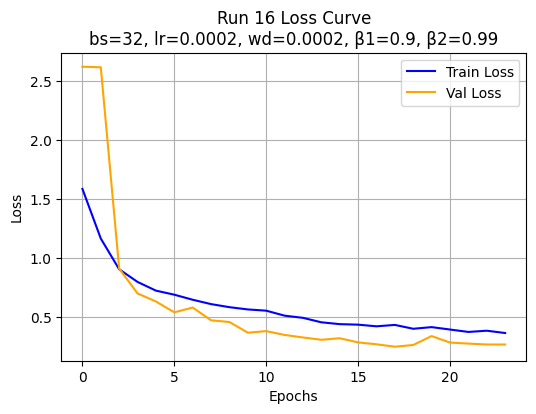

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
Test Accuracy: 0.9417, F1-score: 0.9410
Run 17: batch_size=32, lr=0.0002, weight_decay=0.0005, beta1=0.85, beta2=0.99
Epoch 1/60
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3020 - loss: 1.7783
Epoch 1: val_loss improved from inf to 2.33646, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.3031 - loss: 1.7752 - val_accuracy: 0.1417 - val_loss: 2.3365 - learning_rate: 2.0000e-04
Epoch 2/60
218/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5172 - loss: 1.2507
Epoch 2: val_loss did not improve from 2.33646
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5181 - loss: 1.2487 - val_accuracy: 0.1583 - val_loss: 2.6672 - learning_rate: 2.0000e-04
Epoch 3/60
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5944 - loss: 1.0575
Epoch 3: val_loss improved from 2.33646 to 1.08136, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5945 -

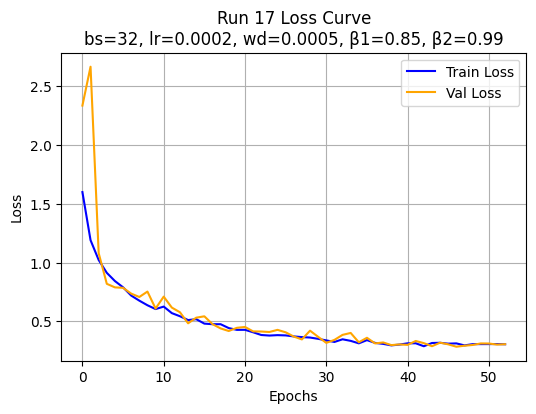

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step
Test Accuracy: 0.8833, F1-score: 0.8820
Run 18: batch_size=32, lr=0.0002, weight_decay=0.0005, beta1=0.9, beta2=0.99
Epoch 1/60
219/225 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3230 - loss: 1.7577
Epoch 1: val_loss improved from inf to 2.33580, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.3250 - loss: 1.7522 - val_accuracy: 0.1183 - val_loss: 2.3358 - learning_rate: 2.0000e-04
Epoch 2/60
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5057 - loss: 1.2383
Epoch 2: val_loss did not improve from 2.33580
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5060 - loss: 1.2370 - val_accuracy: 0.1417 - val_loss: 2.9780 - learning_rate: 2.0000e-04
Epoch 3/60
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5624 - loss: 1.0497
Epoch 3: val_loss improved from 2.33580 to 1.21462, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5625 

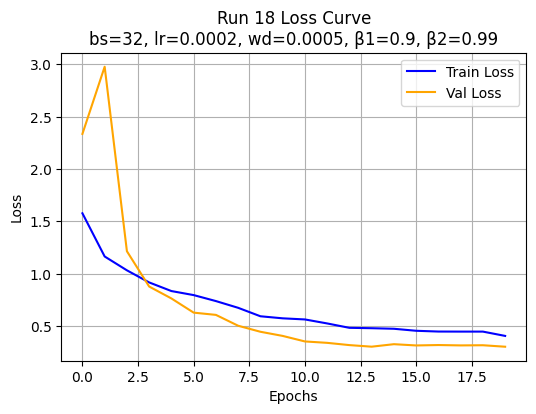

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step
Test Accuracy: 0.9067, F1-score: 0.9058

All results sorted by accuracy:
    batch_size       lr  weight_decay  beta_1  beta_2  accuracy  f1_score
11          32  0.00010        0.0005    0.90    0.99  0.953333  0.953267
15          32  0.00020        0.0002    0.90    0.99  0.941667  0.940985
6           32  0.00010        0.0001    0.85    0.99  0.930000  0.929673
12          32  0.00020        0.0001    0.85    0.99  0.916667  0.915848
17          32  0.00020        0.0005    0.90    0.99  0.906667  0.905837
4           32  0.00005        0.0005    0.85    0.99  0.903333  0.902298
10          32  0.00010        0.0005    0.85    0.99  0.885000  0.883343
16          32  0.00020        0.0005    0.85    0.99  0.883333  0.882020
9           32  0.00010        0.0002    0.90    0.99  0.863333  0.861561
14          32  0.00020        0.0002    0.85    0.99  0.861667  0.859829
0           32  0.00005        0.0001    0.85    0.99  0.843333  0.83848

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# ===== HYPERPARAMETER GRID =====
batch_sizes = [32]
learning_rates = [5e-5, 1e-4, 2e-4]
weight_decays = [1e-4, 2e-4, 5e-4]
beta_1_list = [0.85, 0.9]
beta_2_list = [0.99]

# Fixed hyperparameters
epochs = 60
patience_es = 6
patience_lr = 3
min_delta = 5e-4
checkpoint_path = "enhanced_best_model.keras"
dropout_rates = [0.05, 0.09, 0.14, 0.19, 0.20, 0.37]
alpha = 1.0
snr_range = (5, 25)
augmentation_factor = 2

results = []

# ===== MANUAL GRID SEARCH WITH LOSS PLOTS =====
for idx, (batch_size, lr, wd, b1, b2) in enumerate(itertools.product(batch_sizes, learning_rates, weight_decays, beta_1_list, beta_2_list)):
    print("="*60)
    print(f"Run {idx+1}: batch_size={batch_size}, lr={lr}, weight_decay={wd}, beta1={b1}, beta2={b2}")

    # Create model
    model = EnhancedOptimizedCNN(input_shape=(28,28,2), num_classes=num_classes, alpha=alpha)
    enhanced_model = model.create_model(dropout_rates)

    # Create augmentor
    augmentor = AdvancedRFAugmentation(snr_range=snr_range, augmentation_factor=augmentation_factor)

    # Create training pipeline
    pipeline = ClassWeightedTrainingPipeline(enhanced_model, augmentor, classes)

    # Train model
    history = pipeline.train_enhanced_model(
        X_train=Xtrain,
        y_train=Ytrain,
        Xtest=Xtest,
        Ytest=Ytest,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=wd,
        beta_1=b1,
        beta_2=b2,
        patience_es=patience_es,
        patience_lr=patience_lr,
        min_delta=min_delta,
        checkpoint_path=checkpoint_path
    )

    # Plot loss curve for this run
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    plt.title(f"Run {idx+1} Loss Curve\nbs={batch_size}, lr={lr}, wd={wd}, β1={b1}, β2={b2}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    y_pred_probs = enhanced_model.predict(Xtest)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(Ytest, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

    results.append({
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': wd,
        'beta_1': b1,
        'beta_2': b2,
        'accuracy': acc,
        'f1_score': f1
    })

# ===== Convert results to DataFrame for analysis =====
results_df = pd.DataFrame(results)
print("\nAll results sorted by accuracy:")
print(results_df.sort_values(by='accuracy', ascending=False))


Run 1: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.99, alpha=0.7
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1784 - loss: 2.0248
Epoch 1: val_loss improved from inf to 2.01529, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.1785 - loss: 2.0245 - val_accuracy: 0.0283 - val_loss: 2.0153 - learning_rate: 5.0000e-05
Epoch 2/40
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2588 - loss: 1.8454
Epoch 2: val_loss improved from 2.01529 to 1.77415, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.2589 - loss: 1.8451 - val_accuracy: 0.1700 - val_loss: 1.7742 - learning_rate: 5.0000e-05
Epoch 3/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3170 - loss: 1.7223
Epoch 3: val_loss improved from 1.77415 to 1.66802, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 9

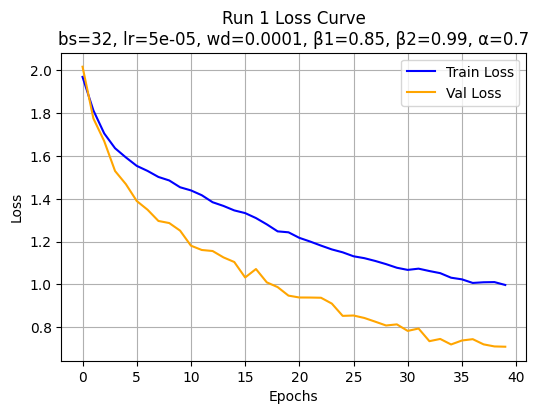

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
Test Accuracy: 0.7217, F1-score: 0.7133
Run 2: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.99, alpha=0.7
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
515/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1834 - loss: 2.0411
Epoch 1: val_loss improved from inf to 2.00443, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.1845 - loss: 2.0395 - val_accuracy: 0.1583 - val_loss: 2.0044 - learning_rate: 5.0000e-05
Epoch 2/40
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2894 - loss: 1.8018
Epoch 2: val_loss improved from 2.00443 to 1.70277, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2895 - loss: 1.8014 - val_accuracy: 0.2500 - val_loss: 1.7028 - learning_rate: 5.0000e-05
Epoch 3/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3349 - loss: 1.6731
Epoch 3: val_loss improved from 1.70277 to 1.594

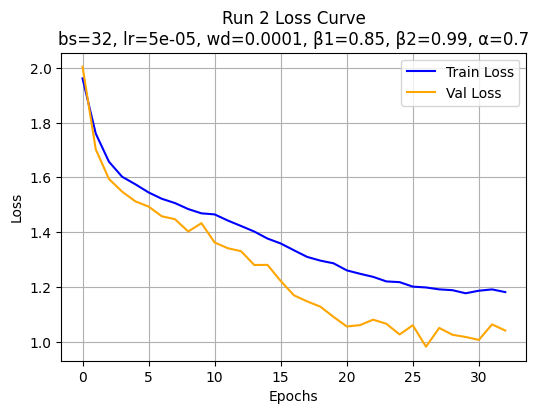

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
Test Accuracy: 0.4950, F1-score: 0.4683
Run 3: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.99, alpha=0.7
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1397 - loss: 2.1286
Epoch 1: val_loss improved from inf to 1.99860, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.1404 - loss: 2.1273 - val_accuracy: 0.1383 - val_loss: 1.9986 - learning_rate: 5.0000e-05
Epoch 2/40
516/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2809 - loss: 1.8463
Epoch 2: val_loss improved from 1.99860 to 1.83578, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2812 - loss: 1.8455 - val_accuracy: 0.1383 - val_loss: 1.8358 - learning_rate: 5.0000e-05
Epoch 3/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3196 - loss: 1.7224
Epoch 3: val_loss improved from 1.83578 to 1.73872

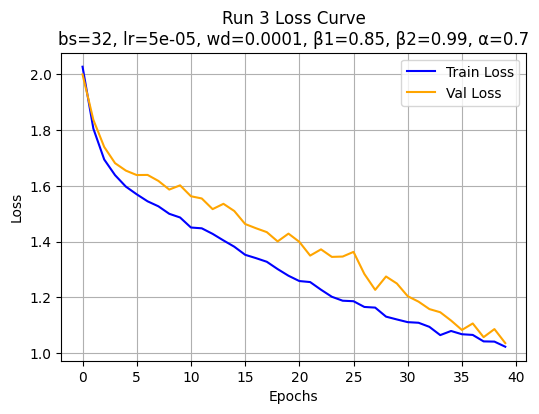

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
Test Accuracy: 0.5233, F1-score: 0.4890
Run 4: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.99, alpha=1.0
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2179 - loss: 1.9648
Epoch 1: val_loss improved from inf to 2.12648, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.2184 - loss: 1.9638 - val_accuracy: 0.1383 - val_loss: 2.1265 - learning_rate: 5.0000e-05
Epoch 2/40
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3223 - loss: 1.7235
Epoch 2: val_loss improved from 2.12648 to 1.71675, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3225 - loss: 1.7229 - val_accuracy: 0.1833 - val_loss: 1.7167 - learning_rate: 5.0000e-05
Epoch 3/40
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3599 - loss: 1.6084
Epoch 3: val_loss improved from 1.71675 to 1.591

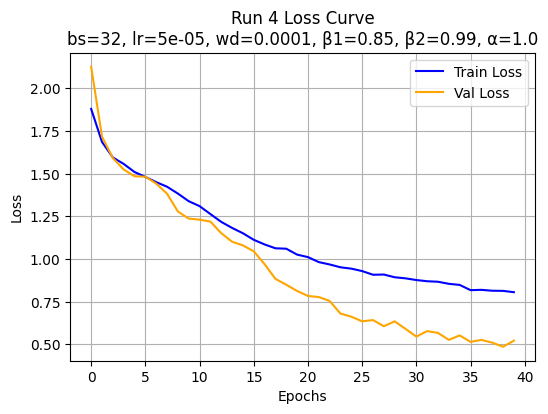

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step
Test Accuracy: 0.8067, F1-score: 0.8012
Run 5: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.99, alpha=1.0
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2037 - loss: 1.9814
Epoch 1: val_loss improved from inf to 2.20907, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.2040 - loss: 1.9808 - val_accuracy: 0.1400 - val_loss: 2.2091 - learning_rate: 5.0000e-05
Epoch 2/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3146 - loss: 1.7353
Epoch 2: val_loss improved from 2.20907 to 2.03762, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3146 - loss: 1.7352 - val_accuracy: 0.1400 - val_loss: 2.0376 - learning_rate: 5.0000e-05
Epoch 3/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3439 - loss: 1.6327
Epoch 3: val_loss improved from 2.03762 to 1.99

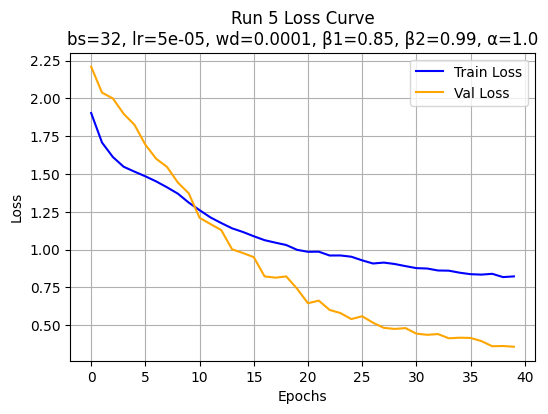

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
Test Accuracy: 0.8850, F1-score: 0.8836
Run 6: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.99, alpha=1.0
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1785 - loss: 1.9959
Epoch 1: val_loss improved from inf to 2.08026, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.1787 - loss: 1.9955 - val_accuracy: 0.1750 - val_loss: 2.0803 - learning_rate: 5.0000e-05
Epoch 2/40
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2555 - loss: 1.8279
Epoch 2: val_loss improved from 2.08026 to 1.82874, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2558 - loss: 1.8273 - val_accuracy: 0.2333 - val_loss: 1.8287 - learning_rate: 5.0000e-05
Epoch 3/40
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3100 - loss: 1.7180
Epoch 3: val_loss improved from 1.82874 to 1.7249

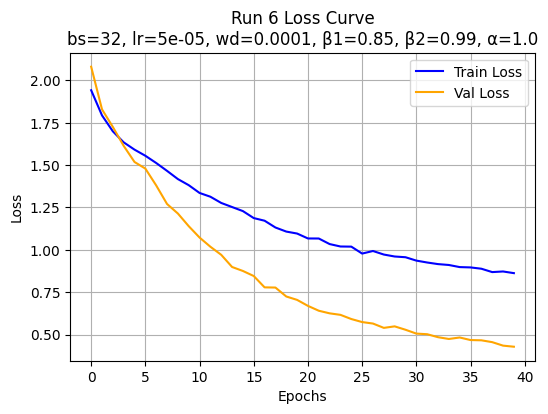

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
Test Accuracy: 0.8400, F1-score: 0.8373
Run 7: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.99, alpha=0.7
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1889 - loss: 2.0050
Epoch 1: val_loss improved from inf to 2.07012, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.1891 - loss: 2.0047 - val_accuracy: 0.1383 - val_loss: 2.0701 - learning_rate: 5.0000e-05
Epoch 2/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2736 - loss: 1.8256
Epoch 2: val_loss improved from 2.07012 to 1.89331, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2737 - loss: 1.8251 - val_accuracy: 0.1450 - val_loss: 1.8933 - learning_rate: 5.0000e-05
Epoch 3/40
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3220 - loss: 1.6972
Epoch 3: val_loss improved from 1.89331 to 1.7774

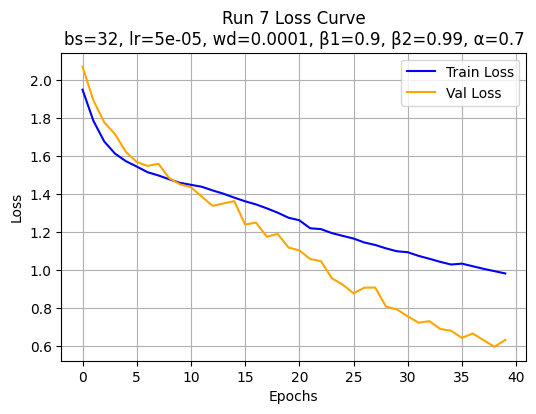

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step
Test Accuracy: 0.7450, F1-score: 0.7414
Run 8: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.99, alpha=0.7
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2067 - loss: 1.9663
Epoch 1: val_loss improved from inf to 2.12391, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.2067 - loss: 1.9660 - val_accuracy: 0.1417 - val_loss: 2.1239 - learning_rate: 5.0000e-05
Epoch 2/40
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2620 - loss: 1.8125
Epoch 2: val_loss improved from 2.12391 to 1.91128, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2621 - loss: 1.8121 - val_accuracy: 0.1800 - val_loss: 1.9113 - learning_rate: 5.0000e-05
Epoch 3/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2993 - loss: 1.7166
Epoch 3: val_loss improved from 1.91128 to 1.8181

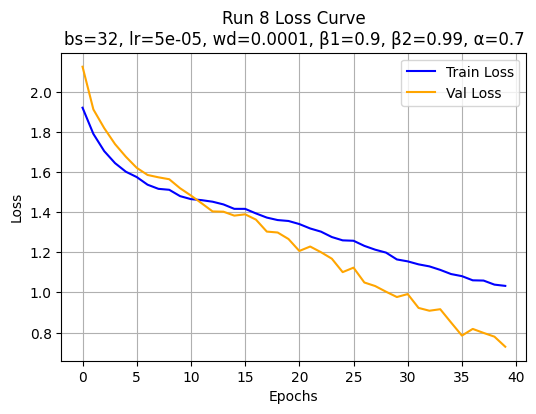

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
Test Accuracy: 0.6967, F1-score: 0.6829
Run 9: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.99, alpha=0.7
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1783 - loss: 2.0471
Epoch 1: val_loss improved from inf to 1.94757, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.1789 - loss: 2.0462 - val_accuracy: 0.1383 - val_loss: 1.9476 - learning_rate: 5.0000e-05
Epoch 2/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2817 - loss: 1.8338
Epoch 2: val_loss improved from 1.94757 to 1.76545, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2817 - loss: 1.8337 - val_accuracy: 0.1550 - val_loss: 1.7655 - learning_rate: 5.0000e-05
Epoch 3/40
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3123 - loss: 1.7373
Epoch 3: val_loss improved from 1.76545 to 1.65284,

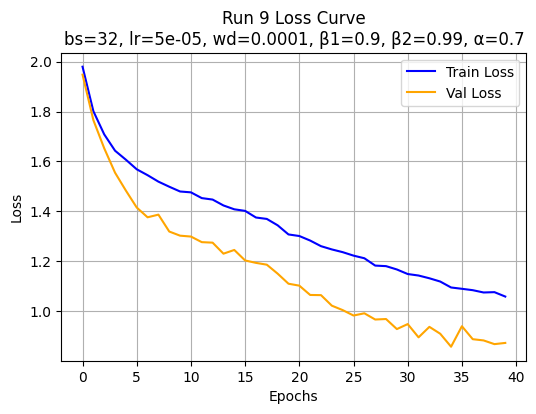

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
Test Accuracy: 0.6433, F1-score: 0.6263
Run 10: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.99, alpha=1.0
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2126 - loss: 1.9856
Epoch 1: val_loss improved from inf to 1.91738, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.2132 - loss: 1.9843 - val_accuracy: 0.1550 - val_loss: 1.9174 - learning_rate: 5.0000e-05
Epoch 2/40
516/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3408 - loss: 1.6973
Epoch 2: val_loss improved from 1.91738 to 1.44859, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3411 - loss: 1.6965 - val_accuracy: 0.3417 - val_loss: 1.4486 - learning_rate: 5.0000e-05
Epoch 3/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3734 - loss: 1.5893
Epoch 3: val_loss improved from 1.44859 to 1.325

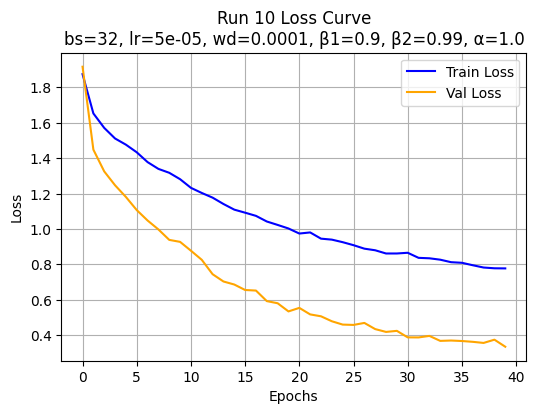

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
Test Accuracy: 0.8867, F1-score: 0.8860
Run 11: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.99, alpha=1.0
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1898 - loss: 2.0234
Epoch 1: val_loss improved from inf to 2.44612, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.1903 - loss: 2.0226 - val_accuracy: 0.1383 - val_loss: 2.4461 - learning_rate: 5.0000e-05
Epoch 2/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2799 - loss: 1.8270
Epoch 2: val_loss improved from 2.44612 to 2.20402, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2800 - loss: 1.8267 - val_accuracy: 0.1383 - val_loss: 2.2040 - learning_rate: 5.0000e-05
Epoch 3/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3282 - loss: 1.7118
Epoch 3: val_loss improved from 2.20402 to 2.177

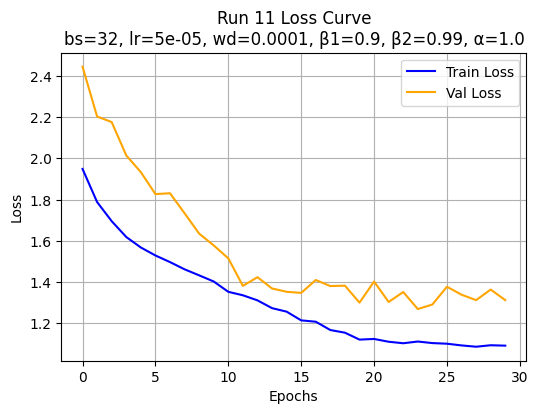

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step
Test Accuracy: 0.3800, F1-score: 0.3425
Run 12: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.99, alpha=1.0
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1967 - loss: 1.9835
Epoch 1: val_loss improved from inf to 2.04771, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.1971 - loss: 1.9827 - val_accuracy: 0.1783 - val_loss: 2.0477 - learning_rate: 5.0000e-05
Epoch 2/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3068 - loss: 1.7560
Epoch 2: val_loss improved from 2.04771 to 1.73056, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3069 - loss: 1.7559 - val_accuracy: 0.2333 - val_loss: 1.7306 - learning_rate: 5.0000e-05
Epoch 3/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3415 - loss: 1.6935
Epoch 3: val_loss improved from 1.73056 to 1.66642

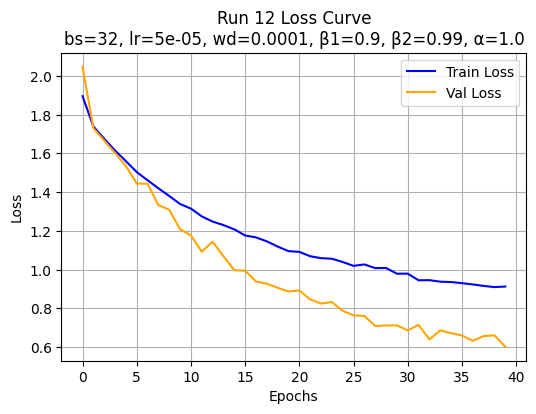

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step
Test Accuracy: 0.7267, F1-score: 0.7156
Run 13: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.99, alpha=0.7
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1790 - loss: 2.0280
Epoch 1: val_loss improved from inf to 2.04183, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.1791 - loss: 2.0279 - val_accuracy: 0.2300 - val_loss: 2.0418 - learning_rate: 5.0000e-05
Epoch 2/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2831 - loss: 1.8026
Epoch 2: val_loss improved from 2.04183 to 1.82296, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2833 - loss: 1.8023 - val_accuracy: 0.1667 - val_loss: 1.8230 - learning_rate: 5.0000e-05
Epoch 3/40
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3310 - loss: 1.6801
Epoch 3: val_loss improved from 1.82296 to 1.6

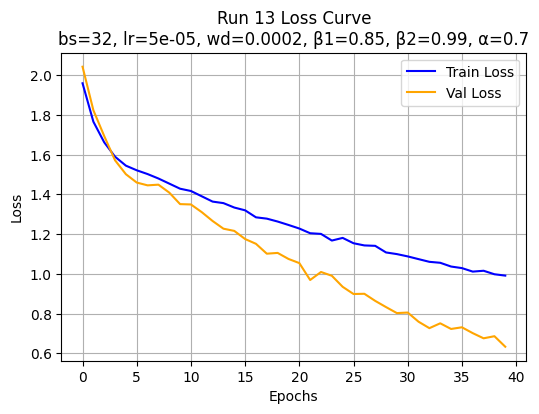

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
Test Accuracy: 0.7300, F1-score: 0.7228
Run 14: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.99, alpha=0.7
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1750 - loss: 2.0332
Epoch 1: val_loss improved from inf to 1.99362, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.1753 - loss: 2.0326 - val_accuracy: 0.1383 - val_loss: 1.9936 - learning_rate: 5.0000e-05
Epoch 2/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2719 - loss: 1.7973
Epoch 2: val_loss improved from 1.99362 to 1.80997, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2719 - loss: 1.7971 - val_accuracy: 0.1483 - val_loss: 1.8100 - learning_rate: 5.0000e-05
Epoch 3/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3224 - loss: 1.6934
Epoch 3: val_loss improved from 1.80997 to 1.68

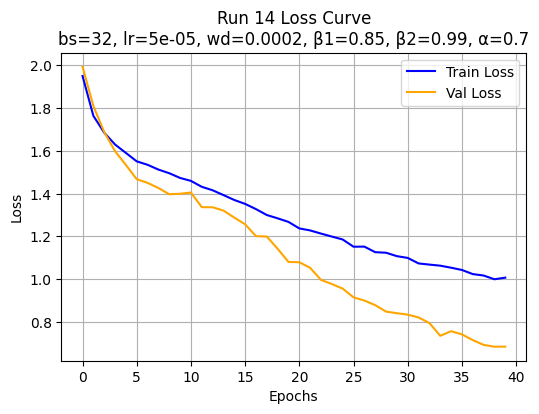

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
Test Accuracy: 0.7033, F1-score: 0.6910
Run 15: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.99, alpha=0.7
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1759 - loss: 2.0462
Epoch 1: val_loss improved from inf to 2.14919, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.1764 - loss: 2.0450 - val_accuracy: 0.1383 - val_loss: 2.1492 - learning_rate: 5.0000e-05
Epoch 2/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2442 - loss: 1.8555
Epoch 2: val_loss improved from 2.14919 to 2.07554, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2445 - loss: 1.8551 - val_accuracy: 0.1383 - val_loss: 2.0755 - learning_rate: 5.0000e-05
Epoch 3/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2922 - loss: 1.7584
Epoch 3: val_loss improved from 2.07554 to 2.0287

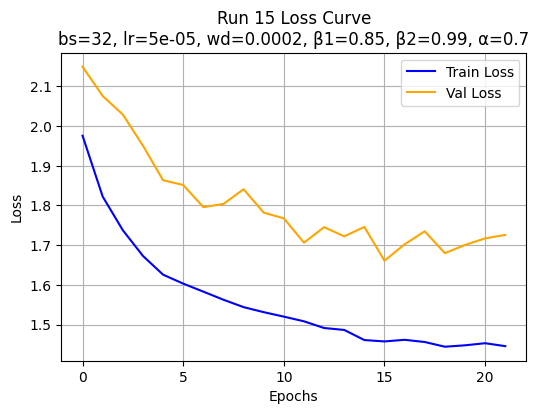

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
Test Accuracy: 0.2983, F1-score: 0.2149
Run 16: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.99, alpha=1.0
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2277 - loss: 1.9960
Epoch 1: val_loss improved from inf to 1.99393, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.2278 - loss: 1.9958 - val_accuracy: 0.1733 - val_loss: 1.9939 - learning_rate: 5.0000e-05
Epoch 2/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3264 - loss: 1.7288
Epoch 2: val_loss improved from 1.99393 to 1.63166, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3266 - loss: 1.7285 - val_accuracy: 0.2900 - val_loss: 1.6317 - learning_rate: 5.0000e-05
Epoch 3/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3575 - loss: 1.6419
Epoch 3: val_loss improved from 1.63166 to 1.52

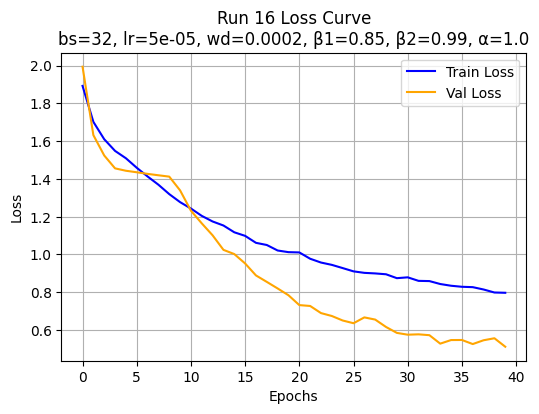

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
Test Accuracy: 0.7917, F1-score: 0.7843
Run 17: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.99, alpha=1.0
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2003 - loss: 1.9832
Epoch 1: val_loss improved from inf to 2.32455, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.2005 - loss: 1.9828 - val_accuracy: 0.1400 - val_loss: 2.3246 - learning_rate: 5.0000e-05
Epoch 2/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3157 - loss: 1.7434
Epoch 2: val_loss improved from 2.32455 to 2.00724, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3157 - loss: 1.7433 - val_accuracy: 0.1400 - val_loss: 2.0072 - learning_rate: 5.0000e-05
Epoch 3/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3555 - loss: 1.6276
Epoch 3: val_loss improved from 2.00724 to 2.00

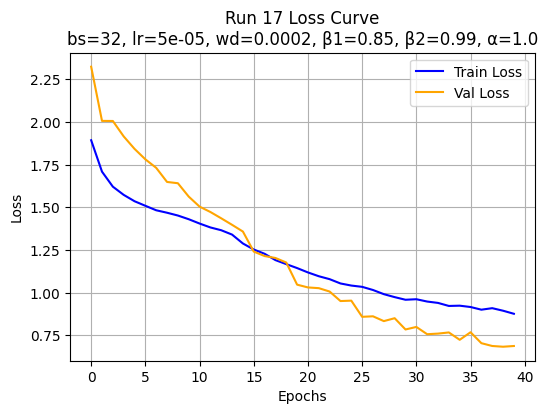

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
Test Accuracy: 0.6533, F1-score: 0.6380
Run 18: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.99, alpha=1.0
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1613 - loss: 2.0871
Epoch 1: val_loss improved from inf to 2.13648, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.1616 - loss: 2.0858 - val_accuracy: 0.0500 - val_loss: 2.1365 - learning_rate: 5.0000e-05
Epoch 2/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2801 - loss: 1.8345
Epoch 2: val_loss improved from 2.13648 to 1.84308, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2803 - loss: 1.8341 - val_accuracy: 0.2633 - val_loss: 1.8431 - learning_rate: 5.0000e-05
Epoch 3/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3361 - loss: 1.6888
Epoch 3: val_loss improved from 1.84308 to 1.7719

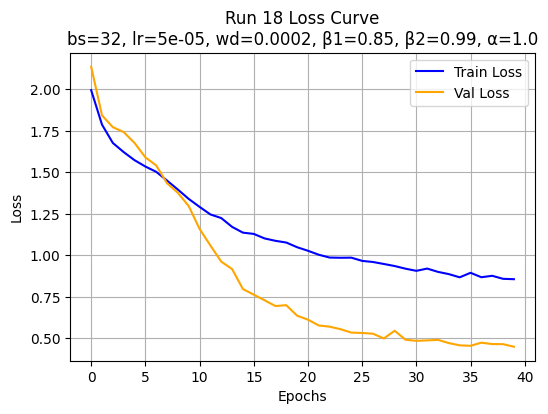

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
Test Accuracy: 0.8267, F1-score: 0.8233
Run 19: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.99, alpha=0.7
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1772 - loss: 2.0317
Epoch 1: val_loss improved from inf to 1.85655, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.1774 - loss: 2.0313 - val_accuracy: 0.3017 - val_loss: 1.8565 - learning_rate: 5.0000e-05
Epoch 2/40
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3008 - loss: 1.7882
Epoch 2: val_loss improved from 1.85655 to 1.55291, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3010 - loss: 1.7877 - val_accuracy: 0.3683 - val_loss: 1.5529 - learning_rate: 5.0000e-05
Epoch 3/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3528 - loss: 1.6323
Epoch 3: val_loss improved from 1.55291 to 1.448

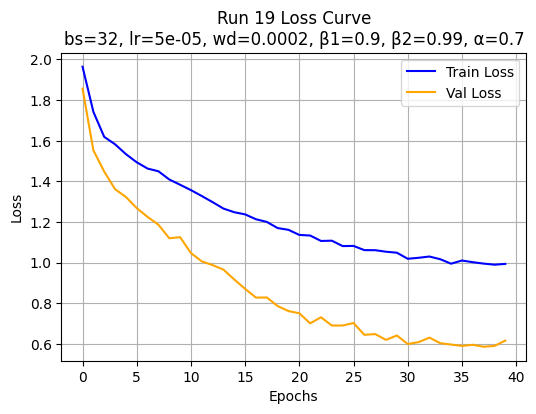

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
Test Accuracy: 0.7950, F1-score: 0.7882
Run 20: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.99, alpha=0.7
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2015 - loss: 2.0251
Epoch 1: val_loss improved from inf to 2.07284, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.2016 - loss: 2.0247 - val_accuracy: 0.1383 - val_loss: 2.0728 - learning_rate: 5.0000e-05
Epoch 2/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2722 - loss: 1.8516
Epoch 2: val_loss improved from 2.07284 to 1.96968, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2722 - loss: 1.8515 - val_accuracy: 0.1383 - val_loss: 1.9697 - learning_rate: 5.0000e-05
Epoch 3/40
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3123 - loss: 1.7586
Epoch 3: val_loss improved from 1.96968 to 1.888

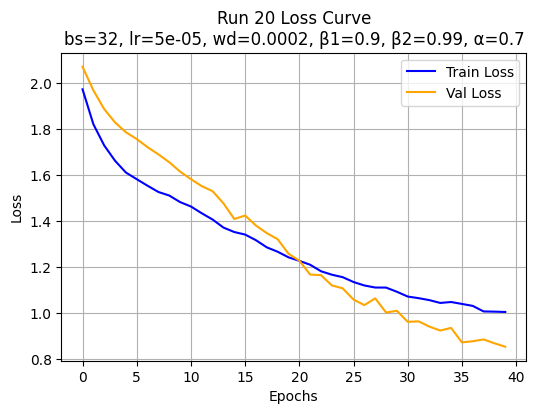

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step
Test Accuracy: 0.5717, F1-score: 0.5485
Run 21: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.99, alpha=0.7
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1763 - loss: 2.0480
Epoch 1: val_loss improved from inf to 1.84283, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.1764 - loss: 2.0478 - val_accuracy: 0.2467 - val_loss: 1.8428 - learning_rate: 5.0000e-05
Epoch 2/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3065 - loss: 1.7746
Epoch 2: val_loss improved from 1.84283 to 1.64342, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3066 - loss: 1.7745 - val_accuracy: 0.3350 - val_loss: 1.6434 - learning_rate: 5.0000e-05
Epoch 3/40
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3445 - loss: 1.6673
Epoch 3: val_loss improved from 1.64342 to 1.57271

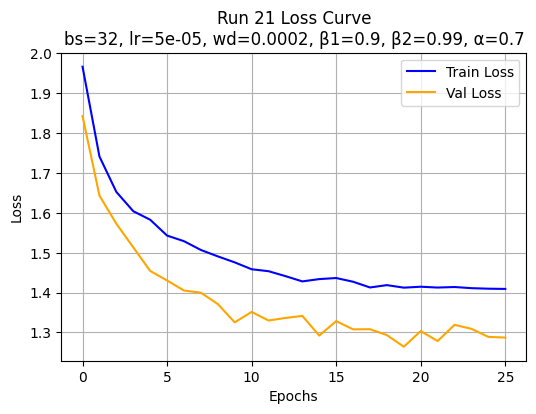

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
Test Accuracy: 0.4717, F1-score: 0.3956
Run 22: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.99, alpha=1.0
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1880 - loss: 2.0337
Epoch 1: val_loss improved from inf to 1.92725, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.1881 - loss: 2.0335 - val_accuracy: 0.2750 - val_loss: 1.9273 - learning_rate: 5.0000e-05
Epoch 2/40
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3336 - loss: 1.6976
Epoch 2: val_loss improved from 1.92725 to 1.52963, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3339 - loss: 1.6970 - val_accuracy: 0.2933 - val_loss: 1.5296 - learning_rate: 5.0000e-05
Epoch 3/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3728 - loss: 1.5843
Epoch 3: val_loss improved from 1.52963 to 1.419

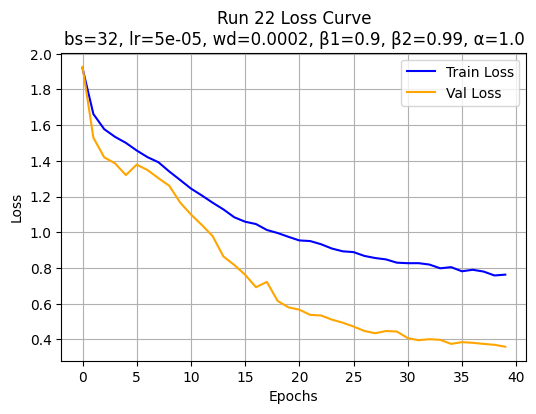

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
Test Accuracy: 0.8617, F1-score: 0.8564
Run 23: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.99, alpha=1.0
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2083 - loss: 1.9933
Epoch 1: val_loss improved from inf to 2.21587, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.2086 - loss: 1.9928 - val_accuracy: 0.1383 - val_loss: 2.2159 - learning_rate: 5.0000e-05
Epoch 2/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3103 - loss: 1.7464
Epoch 2: val_loss improved from 2.21587 to 1.93467, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3104 - loss: 1.7463 - val_accuracy: 0.1417 - val_loss: 1.9347 - learning_rate: 5.0000e-05
Epoch 3/40
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3579 - loss: 1.6544
Epoch 3: val_loss improved from 1.93467 to 1.871

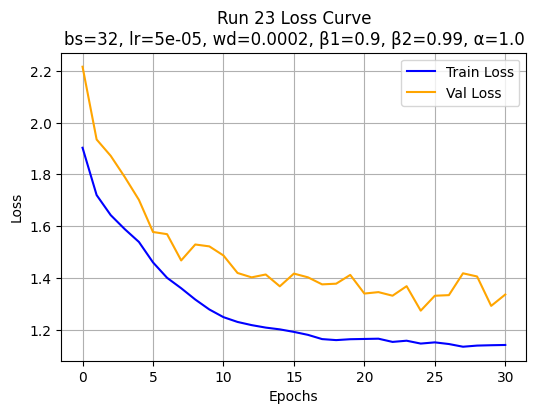

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
Test Accuracy: 0.4000, F1-score: 0.3436
Run 24: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.99, alpha=1.0
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2082 - loss: 1.9733
Epoch 1: val_loss improved from inf to 2.10222, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.2083 - loss: 1.9731 - val_accuracy: 0.1550 - val_loss: 2.1022 - learning_rate: 5.0000e-05
Epoch 2/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2846 - loss: 1.7864
Epoch 2: val_loss improved from 2.10222 to 2.00006, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2846 - loss: 1.7862 - val_accuracy: 0.1550 - val_loss: 2.0001 - learning_rate: 5.0000e-05
Epoch 3/40
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3343 - loss: 1.6715
Epoch 3: val_loss improved from 2.00006 to 1.92344

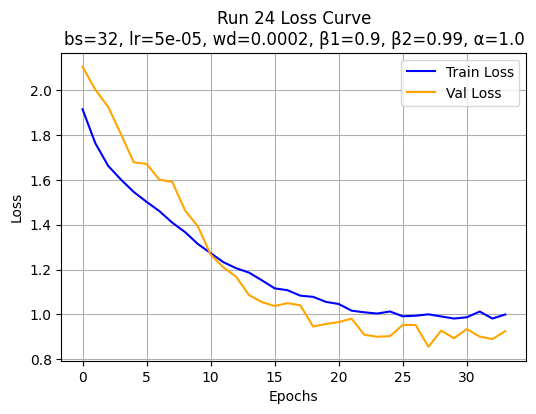

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
Test Accuracy: 0.5667, F1-score: 0.5312
Run 25: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.99, alpha=0.7
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1454 - loss: 2.0750
Epoch 1: val_loss improved from inf to 1.94580, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.1459 - loss: 2.0742 - val_accuracy: 0.1383 - val_loss: 1.9458 - learning_rate: 5.0000e-05
Epoch 2/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3209 - loss: 1.7634
Epoch 2: val_loss improved from 1.94580 to 1.64435, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3210 - loss: 1.7631 - val_accuracy: 0.2383 - val_loss: 1.6444 - learning_rate: 5.0000e-05
Epoch 3/40
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3424 - loss: 1.6718
Epoch 3: val_loss improved from 1.64435 to 1.55

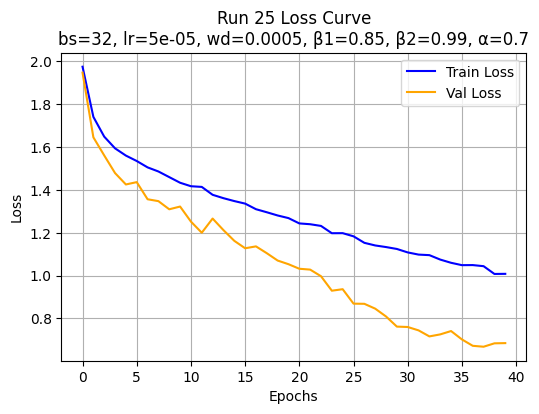

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
Test Accuracy: 0.7100, F1-score: 0.6982
Run 26: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.99, alpha=0.7
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2046 - loss: 2.0400
Epoch 1: val_loss improved from inf to 1.97879, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.2047 - loss: 2.0398 - val_accuracy: 0.1383 - val_loss: 1.9788 - learning_rate: 5.0000e-05
Epoch 2/40
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2676 - loss: 1.8670
Epoch 2: val_loss improved from 1.97879 to 1.92021, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2677 - loss: 1.8666 - val_accuracy: 0.1383 - val_loss: 1.9202 - learning_rate: 5.0000e-05
Epoch 3/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2871 - loss: 1.7949
Epoch 3: val_loss improved from 1.92021 to 1.87

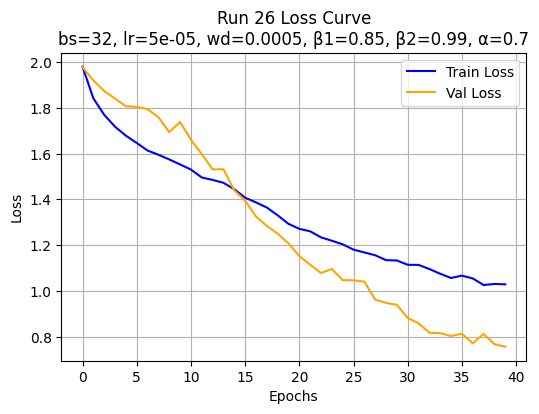

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step
Test Accuracy: 0.6767, F1-score: 0.6570
Run 27: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.99, alpha=0.7
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1965 - loss: 2.0515
Epoch 1: val_loss improved from inf to 2.15978, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.1966 - loss: 2.0509 - val_accuracy: 0.1383 - val_loss: 2.1598 - learning_rate: 5.0000e-05
Epoch 2/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2590 - loss: 1.8773
Epoch 2: val_loss improved from 2.15978 to 2.10898, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2591 - loss: 1.8773 - val_accuracy: 0.1383 - val_loss: 2.1090 - learning_rate: 5.0000e-05
Epoch 3/40
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2988 - loss: 1.7824
Epoch 3: val_loss did not improve from 2.10898
52

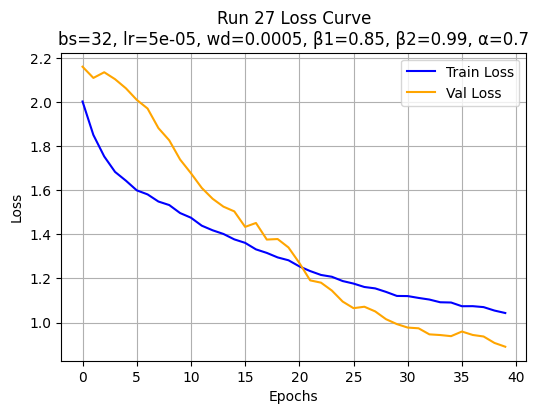

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
Test Accuracy: 0.5683, F1-score: 0.5347
Run 28: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.99, alpha=1.0
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2216 - loss: 2.0139
Epoch 1: val_loss improved from inf to 2.09258, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.2217 - loss: 2.0137 - val_accuracy: 0.1400 - val_loss: 2.0926 - learning_rate: 5.0000e-05
Epoch 2/40
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3235 - loss: 1.7324
Epoch 2: val_loss improved from 2.09258 to 1.72068, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3236 - loss: 1.7321 - val_accuracy: 0.2617 - val_loss: 1.7207 - learning_rate: 5.0000e-05
Epoch 3/40
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3577 - loss: 1.6115
Epoch 3: val_loss improved from 1.72068 to 1.58

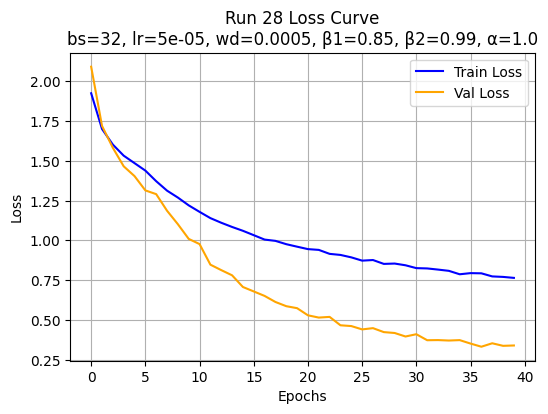

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
Test Accuracy: 0.9067, F1-score: 0.9063
Run 29: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.99, alpha=1.0
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1836 - loss: 2.0378
Epoch 1: val_loss improved from inf to 2.46960, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.1843 - loss: 2.0361 - val_accuracy: 0.1383 - val_loss: 2.4696 - learning_rate: 5.0000e-05
Epoch 2/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3020 - loss: 1.7544
Epoch 2: val_loss improved from 2.46960 to 1.78267, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3022 - loss: 1.7540 - val_accuracy: 0.2233 - val_loss: 1.7827 - learning_rate: 5.0000e-05
Epoch 3/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3467 - loss: 1.6484
Epoch 3: val_loss improved from 1.78267 to 1.63

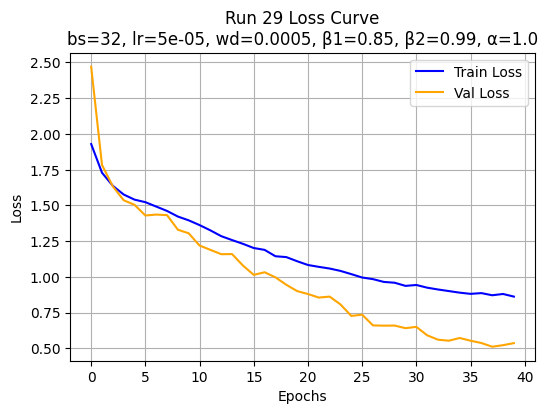

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
Test Accuracy: 0.7933, F1-score: 0.7904
Run 30: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.99, alpha=1.0
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1670 - loss: 2.0602
Epoch 1: val_loss improved from inf to 2.13750, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.1672 - loss: 2.0600 - val_accuracy: 0.1383 - val_loss: 2.1375 - learning_rate: 5.0000e-05
Epoch 2/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2801 - loss: 1.8360
Epoch 2: val_loss improved from 2.13750 to 2.03982, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.2802 - loss: 1.8356 - val_accuracy: 0.1383 - val_loss: 2.0398 - learning_rate: 5.0000e-05
Epoch 3/40
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3180 - loss: 1.6967
Epoch 3: val_loss improved from 2.03982 to 1.9811

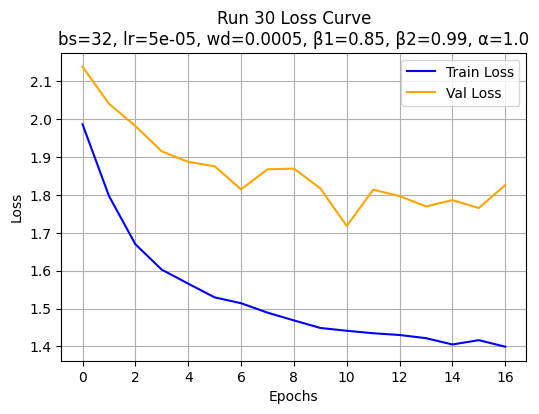

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
Test Accuracy: 0.2917, F1-score: 0.2184
Run 31: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.9, beta2=0.99, alpha=0.7
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]
Epoch 1/40
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1907 - loss: 2.0274
Epoch 1: val_loss improved from inf to 2.00946, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.1912 - loss: 2.0266 - val_accuracy: 0.1633 - val_loss: 2.0095 - learning_rate: 5.0000e-05
Epoch 2/40
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2754 - loss: 1.8675
Epoch 2: val_loss improved from 2.00946 to 1.82745, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2755 - loss: 1.8670 - val_accuracy: 0.1917 - val_loss: 1.8274 - learning_rate: 5.0000e-05
Epoch 3/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3121 - loss: 1.7514
Epoch 3: val_loss improved from 1.82745 to 1.732

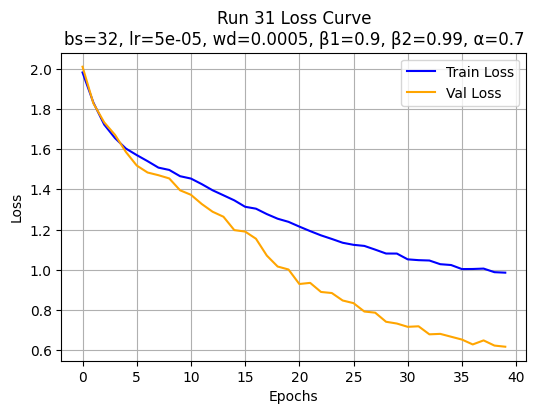

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
Test Accuracy: 0.7533, F1-score: 0.7438
Run 32: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.9, beta2=0.99, alpha=0.7
Dropout rates: [0.08, 0.12, 0.18, 0.22, 0.25, 0.4]
Epoch 1/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2189 - loss: 2.0090
Epoch 1: val_loss improved from inf to 2.07375, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.2192 - loss: 2.0084 - val_accuracy: 0.1400 - val_loss: 2.0737 - learning_rate: 5.0000e-05
Epoch 2/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3023 - loss: 1.8094
Epoch 2: val_loss improved from 2.07375 to 1.82841, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3024 - loss: 1.8090 - val_accuracy: 0.1800 - val_loss: 1.8284 - learning_rate: 5.0000e-05
Epoch 3/40
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3444 - loss: 1.6910
Epoch 3: val_loss improved from 1.82841 to 1.691

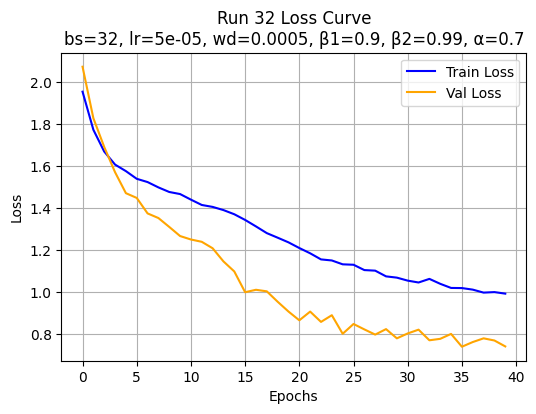

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
Test Accuracy: 0.6350, F1-score: 0.6289
Run 33: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.9, beta2=0.99, alpha=0.7
Dropout rates: [0.1, 0.15, 0.2, 0.25, 0.3, 0.45]
Epoch 1/40
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1854 - loss: 2.0195
Epoch 1: val_loss improved from inf to 2.07236, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.1856 - loss: 2.0189 - val_accuracy: 0.1617 - val_loss: 2.0724 - learning_rate: 5.0000e-05
Epoch 2/40
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2729 - loss: 1.8117
Epoch 2: val_loss improved from 2.07236 to 1.98257, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2730 - loss: 1.8114 - val_accuracy: 0.1400 - val_loss: 1.9826 - learning_rate: 5.0000e-05
Epoch 3/40
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3150 - loss: 1.7213
Epoch 3: val_loss improved from 1.98257 to 1.93553

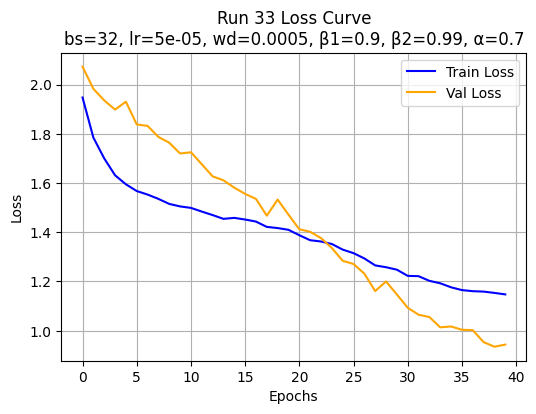

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
Test Accuracy: 0.5567, F1-score: 0.5191
Run 34: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.9, beta2=0.99, alpha=1.0
Dropout rates: [0.05, 0.09, 0.14, 0.19, 0.2, 0.37]


In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# ===== HYPERPARAMETER GRID =====
batch_sizes = [32]  # fixed as you requested
learning_rates = [5e-5, 1e-4, 2e-4]
weight_decays = [1e-4, 2e-4, 5e-4]
beta_1_list = [0.85, 0.9]
beta_2_list = [0.99]

# New: alpha grid and discrete dropout options
alpha_list = [0.7, 1.0]  # width multipliers
dropout_grid = [
    [0.05, 0.09, 0.14, 0.19, 0.20, 0.37],
    [0.08, 0.12, 0.18, 0.22, 0.25, 0.40],
    [0.1, 0.15, 0.20, 0.25, 0.30, 0.45]
]

# Fixed hyperparameters
epochs = 40
patience_es = 6
patience_lr = 3
min_delta = 5e-4
checkpoint_path = "enhanced_best_model.keras"
snr_range = (-10, 25)
augmentation_factor = 6

results = []

# ===== GRID SEARCH INCLUDING ALPHA AND DROPOUT =====
for idx, (batch_size, lr, wd, b1, b2, alpha, dropout_rates) in enumerate(
        itertools.product(batch_sizes, learning_rates, weight_decays, beta_1_list, beta_2_list, alpha_list, dropout_grid)):

    print("="*60)
    print(f"Run {idx+1}: batch_size={batch_size}, lr={lr}, weight_decay={wd}, beta1={b1}, beta2={b2}, alpha={alpha}")
    print(f"Dropout rates: {dropout_rates}")

    # Create model
    model = EnhancedOptimizedCNN(input_shape=(28,28,2), num_classes=num_classes, alpha=alpha)
    enhanced_model = model.create_model(dropout_rates)

    # Create augmentor
    augmentor = AdvancedRFAugmentation(snr_range=snr_range, augmentation_factor=augmentation_factor)

    # Create training pipeline
    pipeline = ClassWeightedTrainingPipeline(enhanced_model, augmentor, classes)

    # Train model
    history = pipeline.train_enhanced_model(
        X_train=Xtrain,
        y_train=Ytrain,
        Xtest=Xtest,
        Ytest=Ytest,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=wd,
        beta_1=b1,
        beta_2=b2,
        patience_es=patience_es,
        patience_lr=patience_lr,
        min_delta=min_delta,
        checkpoint_path=checkpoint_path
    )

    # Plot loss curve for this run
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    plt.title(f"Run {idx+1} Loss Curve\nbs={batch_size}, lr={lr}, wd={wd}, β1={b1}, β2={b2}, α={alpha}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    y_pred_probs = enhanced_model.predict(Xtest)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(Ytest, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

    results.append({
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': wd,
        'beta_1': b1,
        'beta_2': b2,
        'alpha': alpha,
        'dropout_rates': dropout_rates,
        'accuracy': acc,
        'f1_score': f1
    })

# ===== Convert results to DataFrame for analysis =====
results_df = pd.DataFrame(results)
print("\nAll results sorted by accuracy:")
print(results_df.sort_values(by='accuracy', ascending=False))
